# Import all packages

In [1]:
using DifferentialEquations
using OrdinaryDiffEq
using DiffEqBase
using Sundials
using ODEInterfaceDiffEq
using Plots
using Measures
using CSV
using DataFrames
using EasyFit
using StatsPlots
using LinearAlgebra
using Random
using Distributions
using OrdinaryDiffEq
Random.seed!(145975);
using KernelDensity
using LaTeXStrings
using StatsBase
using JLD2
using Trapz

In [2]:
include("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\BayesianInference\\FunctionsBayesInfs.jl")

restructDatInfCompRep_RealExpDat_FixScF (generic function with 1 method)

# Extract Data in Stan Format

In [3]:
mainpath = "C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ProcessedData\\";
paths = [mainpath*"2Mil_Dat.csv", mainpath*"4Mil_Dat.csv", mainpath*"8Mil_Dat.csv"]

3-element Vector{String}:
 "C:\\IBECPostDocDrive\\2024_01_16_" ⋯ 26 bytes ⋯ "ence\\ProcessedData\\2Mil_Dat.csv"
 "C:\\IBECPostDocDrive\\2024_01_16_" ⋯ 26 bytes ⋯ "ence\\ProcessedData\\4Mil_Dat.csv"
 "C:\\IBECPostDocDrive\\2024_01_16_" ⋯ 26 bytes ⋯ "ence\\ProcessedData\\8Mil_Dat.csv"

In [4]:
dat = restructDatInf(paths)

Dict{String, Any} with 14 entries:
  "Means"  => [7719.3 7114.49 7078.58; 5784.22 5374.68 4974.61; … ; -0.332078 -…
  "stsl"   => [78 78 78]
  "obSta"  => [1 2]
  "sts"    => [0 0 0; 15 15 15; … ; 390 390 390; 395 395 395]
  "obser"  => 2
  "Y0us"   => [7719.3 7114.49 7078.58; 0.0 0.0 0.0; 0.0 0.0 0.0]
  "ts"     => [1.0e-20 1.0e-20 1.0e-20; 1.0 1.0 1.0; … ; 394.0 394.0 394.0; 395…
  "itp"    => [0.0, 0.0, 0.0]
  "ncells" => [2 4 8]
  "stslm"  => 78
  "tml"    => 396
  "Erros"  => [919.986 706.515 1071.38; 720.006 455.928 835.636; … ; 4.13944 3.…
  "m"      => 3
  "nts"    => [395 395 395]

In [5]:
poster = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\BayesianInference\\Results\\PosteriorTransp.csv", DataFrame));
posterNT = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\BayesianInference\\Results\\PosteriorNoTransp.csv", DataFrame));
posterMM = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\BayesianInference\\Results\\PosteriorMichMent.csv", DataFrame));
posterCR = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ExperimentalBayesianOED\\Results\\PosteriorCompetitiveRepressionExp_Init_Try1.csv", DataFrame));

# Simulate Posterior Prediction (Quantiles)

In [6]:
include("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\InitalParameterFitPriorDef\\ModelFunctionsAll.jl")

PyruvateHP_NMR_SolveAllMM (generic function with 1 method)

In [7]:
dat2 = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ProcessedData\\2Mil_Dat.csv", DataFrame));
dat4 = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ProcessedData\\4Mil_Dat.csv", DataFrame));
dat8 = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ProcessedData\\8Mil_Dat.csv", DataFrame));

dat = [dat2, dat4, dat8];

# Simulate 3.2 mM Predictions of all models

In [8]:
dat1 = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ProcessedData\\3Mil_3-2mMPyr_Dat.csv", DataFrame));

ScF = dat1[1,2]/(3200*0.12);
PyrCons = [3.2];
ObsPyrCons = PyrCons.*(1000*0.12*ScF);

In [9]:
# Model With Transporter
tsC2 = dat2[1,1]:1:dat2[end,1]
ts = 0:tsC2[end];

posterTR = Array{Any}(undef, length(PyrCons))
for i in 1:length(PyrCons)
    ivss = [ObsPyrCons[i], 0, 0];
    samps = convert.(Int, tsC2);
    SimOnTime1poster, SimOffTime1poster, SimAll1poster  = PyruvateHP_NMR_SolveAllTb(ts, hcat(poster[:,1:2].*2.5, poster[:,4], poster[:,3], poster[:,end].*2.5, zeros(8000)), ivss, samps); # Seems that for this model, instead of 3 milion there is around 2.5, so we will adjust all the simulations for that. 

    posterTR[i] = SimOnTime1poster;
end

# Dims = Up/Down, Observable, Experiment
PosterQuantTR = Array{Any}(undef,2,3,length(PyrCons));

for k in 1:3
    for m in 1:length(PyrCons)
        PosterQuantTR[1,k,m] = [percentile(posterTR[m][j,k,:], 99.5) for j in 1:size(posterTR[m][:,k,1])[1]]; # Up
        PosterQuantTR[2,k,m] = [percentile(posterTR[m][j,k,:], 0.5 ) for j in 1:size(posterTR[m][:,k,1])[1]]; # Down
    end
end

In [10]:
# Model W/O Transporter
posterNT3 = Array{Any}(undef, length(PyrCons))
for i in 1:length(PyrCons)
    ivss = [ObsPyrCons[i], 0];
    samps = convert.(Int, tsC2);
    SimOnTime1poster, SimOffTime1poster, SimAll1poster  = PyruvateHP_NMR_SolveAll(ts, hcat(posterNT[:,1:2].*2.5, posterNT[:,4], posterNT[:,3], zeros(8000)), ivss, samps);
    posterNT3[i] = SimOnTime1poster;
end

# Dims = Up/Down, Observable, Experiment
PosterQuantNT3 = Array{Any}(undef,2,2,length(PyrCons));

for k in 1:2
    for m in 1:length(PyrCons)
        PosterQuantNT3[1,k,m] = [percentile(posterNT3[m][j,k,:], 99.5) for j in 1:size(posterNT3[m][:,k,1])[1]]; # Up
        PosterQuantNT3[2,k,m] = [percentile(posterNT3[m][j,k,:], 0.5 ) for j in 1:size(posterNT3[m][:,k,1])[1]]; # Down
    end
end

In [11]:
2.5/4

0.625

In [11]:
# Model Michaelis Menten
posterSimsMMPre3 = Array{Any}(undef, length(PyrCons))
for i in 1:length(PyrCons)
    samps = convert.(Int, tsC2);
    tmpSim = Array{Any}(undef, size(posterMM)[1])
    for j in 1:size(posterMM)[1]
        ivss = [ObsPyrCons[i], 0, posterMM[j,end]*0.625, 0, 0]; # It is *0.75 because the fit is done with data for 4 million cells, yet the comparison here is for 3 million, so we need to scale the kIN parameter for the number of cells as well as the concentration of LDH
        SimOnTime1poster, SimOffTime1poster, SimAll1poster  = PyruvateHP_NMR_SolveAllMM(ts, vcat(posterMM[j,1]*0.625, posterMM[j,2:6], zeros(1)), ivss, samps);
        tmpSim[j] = SimOnTime1poster;
    end
    posterSimsMMPre3[i] = tmpSim;
end

posterSimsMM3 = Array{Any}(undef, length(PyrCons));
for i in 1:length(PyrCons)
    tmp = zeros(size(posterSimsMMPre3[i][1])[1], size(posterSimsMMPre3[i][1])[2], size(posterSimsMMPre3[i])[1])
    for j in 1:size(posterSimsMMPre3[i])[1]
        tmp[:,:,j] = posterSimsMMPre3[i][j][:,:,1]
    end
    posterSimsMM3[i] = tmp;
end

# Dims = Up/Down, Observable, Experiment
PosterQuantMM3 = Array{Any}(undef,2,5,length(PyrCons));

for k in 1:5
    for m in 1:length(PyrCons)
        PosterQuantMM3[1,k,m] = [percentile(posterSimsMM3[m][j,k,:], 95) for j in 1:size(posterSimsMM3[m][:,k,1])[1]]; # Up
        PosterQuantMM3[2,k,m] = [percentile(posterSimsMM3[m][j,k,:], 5 ) for j in 1:size(posterSimsMM3[m][:,k,1])[1]]; # Down
    end
end

In [12]:
# Competitive Repression Model
posterSimsCRPre3 = Array{Any}(undef, length(PyrCons))
for i in 1:length(PyrCons)
    samps = convert.(Int, tsC2);
    tmpSim = Array{Any}(undef, size(posterCR)[1])
    for j in 1:size(posterCR)[1]
        ivss = [PyrCons[i].*1000, 0, 0, posterCR[j,end-2], posterCR[j,end-1], posterCR[j,end], 0, 0, 0, 0, 0, PyrCons[i].*1000, 0, PyrCons[i].*(1000*0.12*posterCR[1,end-3])];;
        SimOnTime1poster, SimOffTime1poster, SimAll1poster  = PyruvateHP_NMR_SolveAllCp(ts, vcat(posterCR[j,1:end-3], zeros(1)), ivss, samps);
        tmpSim[j] = SimOnTime1poster;
    end
    posterSimsCRPre3[i] = tmpSim;
end

posterSimsCR3 = Array{Any}(undef, length(PyrCons));
for i in 1:length(PyrCons)
    tmp = zeros(size(posterSimsCRPre3[i][1])[1], size(posterSimsCRPre3[i][1])[2], size(posterSimsCRPre3[i])[1])
    for j in 1:size(posterSimsCRPre3[i])[1]
        tmp[:,:,j] = posterSimsCRPre3[i][j][:,:,1]
    end
    posterSimsCR3[i] = tmp;
end

# Dims = Up/Down, Observable, Experiment
PosterQuantCR3 = Array{Any}(undef,2,14,length(PyrCons));

# for k in 1:14
    k = 13
    for m in 1:length(PyrCons)
        PosterQuantCR3[1,k,m] = [percentile(posterSimsCR3[m][j,k,:], 95) for j in 1:size(posterSimsCR3[m][:,k,1])[1]]; # Up
        PosterQuantCR3[2,k,m] = [percentile(posterSimsCR3[m][j,k,:], 5 ) for j in 1:size(posterSimsCR3[m][:,k,1])[1]]; # Down
    end
# end

In [13]:
sims32 = [posterNT3[1], posterTR[1], posterSimsMM3[1], posterSimsCR3[1]];

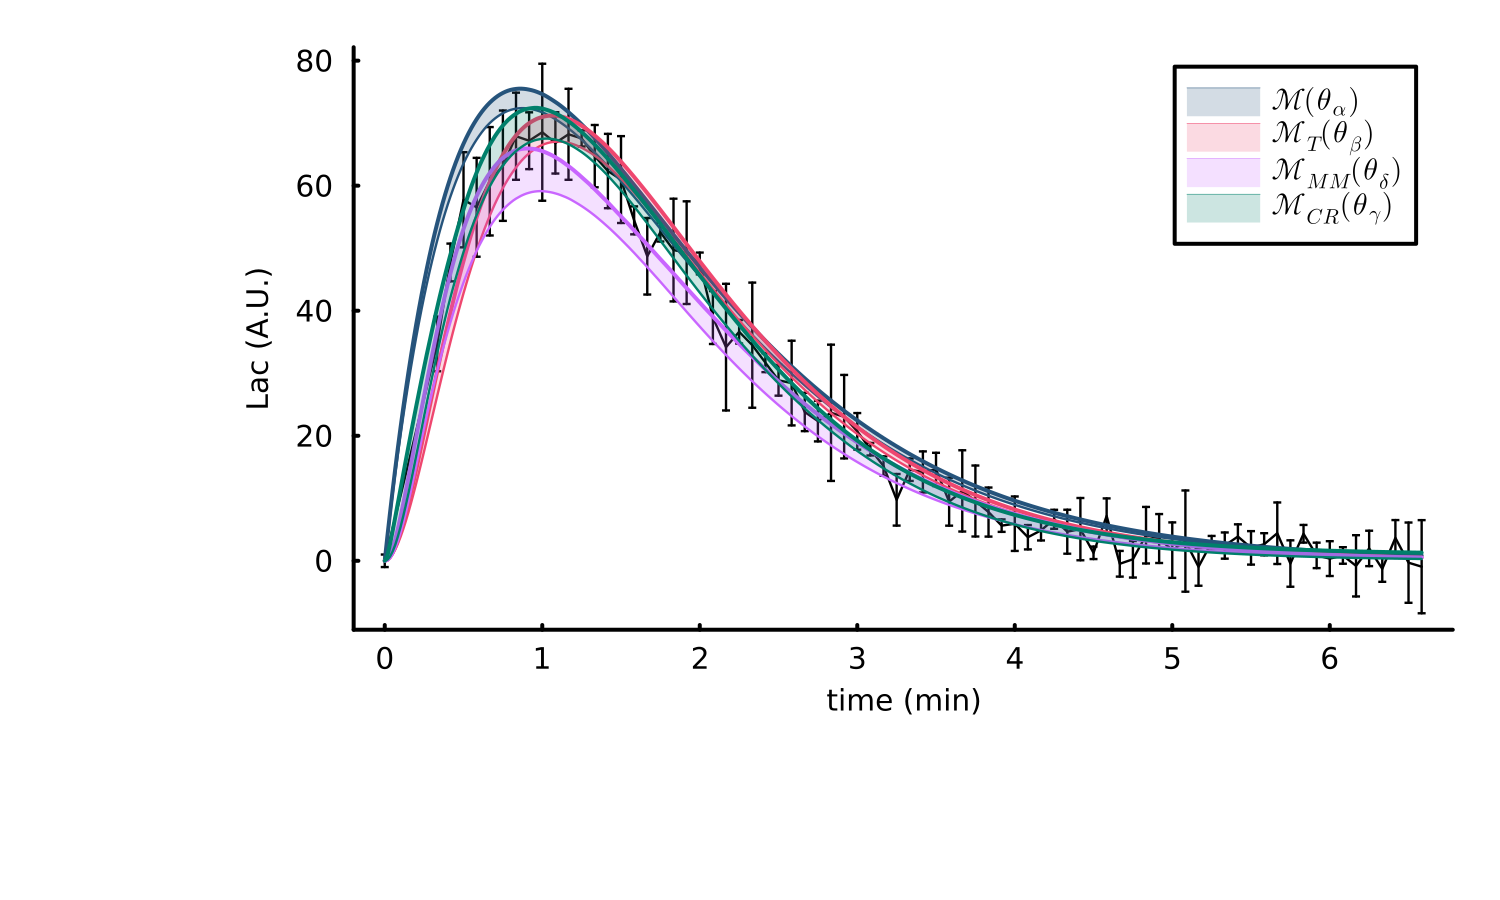

In [14]:
ccpal = ["#26547cff","#ef476fff","#c966ffff","#00806bff"];


PP = plot(dat1[:,1]./60, dat1[:,4], yerror = dat1[:,5], label = "", grid = false, colour="Black", markersize=1, markerstrokewidth=0.2, 
linewidth=0.6, size = (1500,900), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5)

i = 1
plot!(tsC2./60, PosterQuantNT3[1,2,i], label = "",
  xlabel = "time (min)", ylabel = "Lactate (AU)", grid = false, color = ccpal[1])
plot!(tsC2./60, PosterQuantNT3[2,2,i], label = "", linewidth=0.6, color = ccpal[1])
plot!(tsC2./60, PosterQuantNT3[2,2,i], fillrange=PosterQuantNT3[1,2,i], label=L"\mathcal{M}(\theta_{\alpha})", fillalpha=0.2, linewidth=0, color = ccpal[1])


plot!(tsC2./60, PosterQuantTR[1,3,i], label = "",
  xlabel = "time (min)", ylabel = "Lactate (AU)", grid = false, color = ccpal[2])
plot!(tsC2./60, PosterQuantTR[2,3,i], label = "", linewidth=0.6, color = ccpal[2])
plot!(tsC2./60, PosterQuantTR[2,3,i], fillrange=PosterQuantTR[1,3,i], label=L"\mathcal{M}_{T}(\theta_{\beta})", fillalpha=0.2, linewidth=0, color = ccpal[2])


plot!(tsC2./60, PosterQuantMM3[1,5,i], label = "",
  xlabel = "time (min)", ylabel = "Lactate (AU)", grid = false, color = ccpal[3])
plot!(tsC2./60, PosterQuantMM3[2,5,i], label = "", linewidth=0.6, color = ccpal[3])
plot!(tsC2./60, PosterQuantMM3[2,5,i], fillrange=PosterQuantMM3[1,5,i], label=L"\mathcal{M}_{MM}(\theta_{\delta})", fillalpha=0.2, linewidth=0, color = ccpal[3])


plot!(tsC2./60, PosterQuantCR3[1,13,i], label = "",
  xlabel = "time (min)", ylabel = "Lac (A.U.)", grid = false, color = ccpal[4])
plot!(tsC2./60, PosterQuantCR3[2,13,i], label = "", linewidth=0.6, color = ccpal[4])
plot!(tsC2./60, PosterQuantCR3[2,13,i], fillrange=PosterQuantCR3[1,13,i], label=L"\mathcal{M}_{CR}(\theta_{\gamma})", fillalpha=0.2, linewidth=0, color = ccpal[4])


# savefig(PP,"C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\Paper\\Figures\\Figure3Stuff\\AllModelPredictions3.2mM.svg")

display(PP)

In [16]:
inL = [2,3,5,13]
prs = [3,4,5,11]

nRMSE_lac = zeros(4,8000);

for m in 1:4
    for k in 1:8000
        lactmp = sqrt(sum(((sims32[m][1:5:end, inL[m], k][5:end].-dat1[2:end,4]).^2)./dat1[2:end,5].^2)/length(dat1[2:end,4]));
        nRMSE_lac[m,k] = lactmp + log(prs[m]*log(1*77));
    end
end

println("nRMSE lactate: "*string(sum(sum(nRMSE_lac, dims=2)/8000)))

nRMSE lactate: 17.270628820786108


In [17]:
prs = [3,4,5,11]
BIC_lac = zeros(4,8000);

for m in 1:4
    for k in 1:8000
        BIC_lac[m,k] = sum(((sims32[m][1:5:end, inL[m], k][5:end].-dat1[2:end,4]).^2)./dat1[2:end,5].^2) + (prs[m]*log(length(dat1[2:end,4])));;
    end
end

println("BIC lactate: "*string(sum(sum(BIC_lac, dims=2)/8000)))

BIC lactate: 581.7369874116682


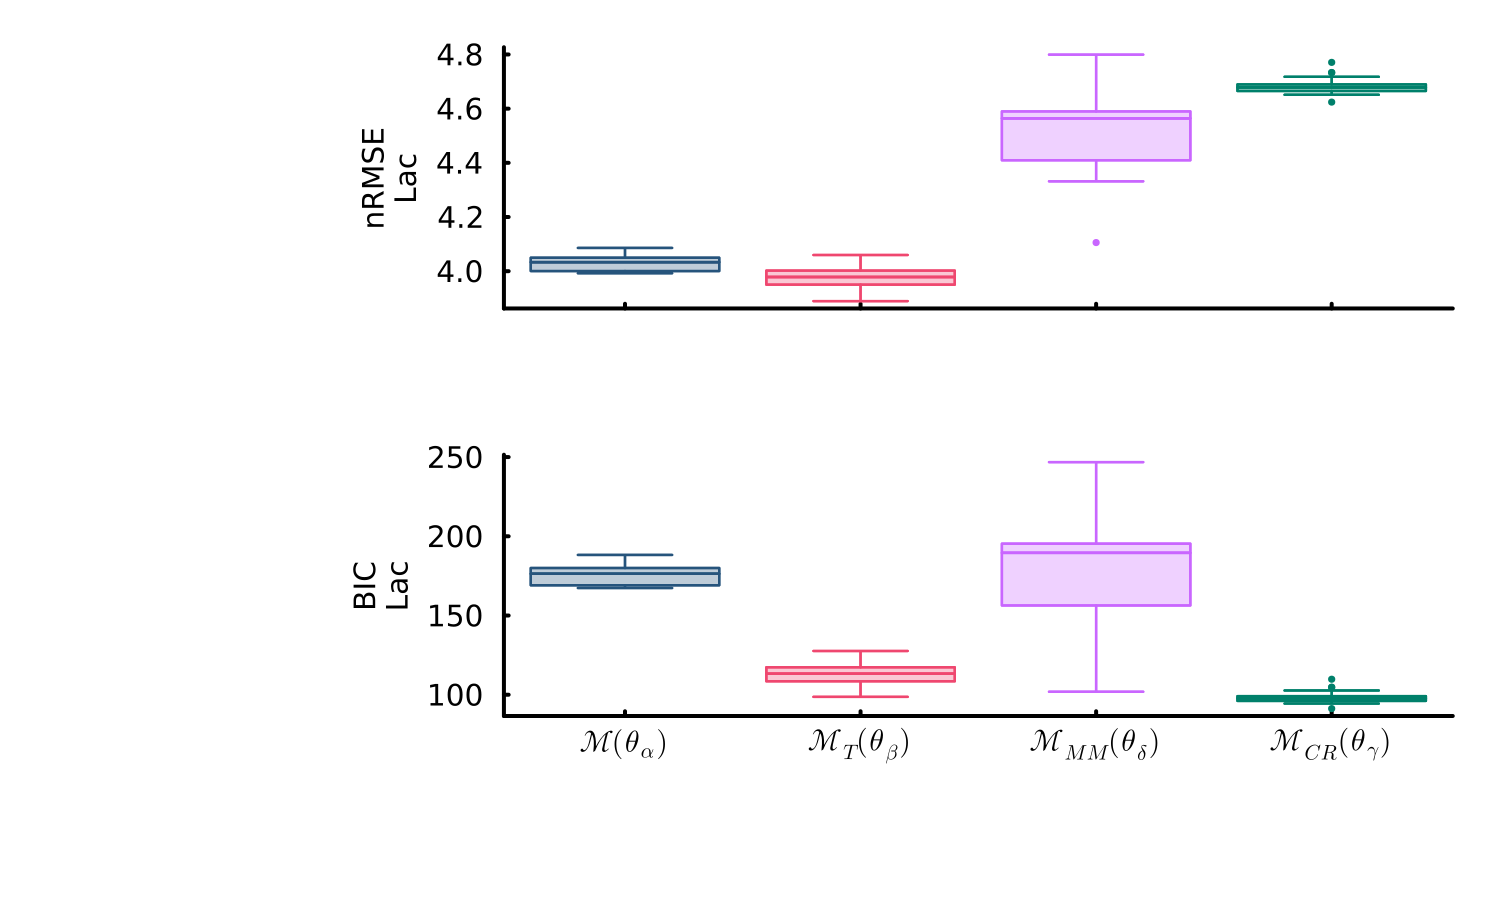

In [18]:

pp2 = boxplot([1 2 3 4], [nRMSE_lac[1,1:20], nRMSE_lac[2,1:20], nRMSE_lac[3,1:20], nRMSE_lac[4,1:20]], ylabel = "nRMSE\nLac", grid = false, label = "", xticks = ([1,2,3,4],["","","",""]), colour = [ccpal[1] ccpal[2] ccpal[3] ccpal[4]], markercolour = [ccpal[1] ccpal[2] ccpal[3] ccpal[4]], markerstrokecolour = [ccpal[1] ccpal[2] ccpal[3] ccpal[4]], linecolor = [ccpal[1] ccpal[2] ccpal[3] ccpal[4]], fillalpha = 0.3)
pp1 = boxplot([1 2 3 4], [BIC_lac[1,1:20], BIC_lac[2,1:20], BIC_lac[3,1:20], BIC_lac[4,1:20]], ylabel = "BIC\nLac", grid = false, label = "", xticks = ([1,2,3,4],[L"\mathcal{M}(\theta_{\alpha})", L"\mathcal{M}_{T}(\theta_{\beta})", L"\mathcal{M}_{MM}(\theta_{\delta})", L"\mathcal{M}_{CR}(\theta_{\gamma})"]), colour = [ccpal[1] ccpal[2] ccpal[3] ccpal[4]], markercolour = [ccpal[1] ccpal[2] ccpal[3] ccpal[4]], markerstrokecolour = [ccpal[1] ccpal[2] ccpal[3] ccpal[4]], linecolor = [ccpal[1] ccpal[2] ccpal[3] ccpal[4]], fillalpha = 0.3)


PP = plot(pp2,pp1, layout = (2,1), markersize=1, markerstrokewidth=0.2, 
linewidth=0.6, size = (1500,900), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5)


savefig(PP,"C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\Paper\\Figures\\Figure3Stuff\\AllModelPredictions3.2mMGOFMets.svg")

display(PP)

## Simulate Experiments To Show Data against Time

In [15]:
# ScF = dat2[1,2]/(3200*0.12);
PyrCons = [0, 0.8,1.6,3.2,6.4,12.8,25.6,40];
ObsPyrCons = PyrCons.*(1000*0.12*ScF);

labs = ["0 mM Pyr", "0.8 mM Pyr", "1.6 mM Pyr", "3.2 mM Pyr","6.4 mM Pyr","12.8 mM Pyr","25.6 mM Pyr","40.0 mM Pyr"];
          # colpal = ["#264653", "#287271", "#2a9d8f", "#e9c46a", "#f4a261", "#ee8959", "#e76f51"]
          #             # colpal = ["#1A2766", "#33255A", "#4B234E", "#642142", "#7D1F36", "#951D2A", "#AE1B1E"]
# colpal = ["#6FE3E1", "#6ACCE2", "#65B4E2", "#619DE3", "#5C86E4", "#576EE4", "#5257E5"]
          #             # colpal = ["#42047E", "#382C83", "#2E5489", "#257C8E", "#1BA493", "#11CC99", "#07F49E"][end:-1:1]
          #             # colpal = ["#FF9900", "#FFC800", "#FFE000", "#FFF700", "#B8F500", "#95E214", "#72CE27"]
          # colpal = ["#F94144", "#F3722C", "#F8961E", "#F9C74F", "#90BE6D", "#43AA8B", "#577590"]
colpal = ["Black", "#E40B0B", "#C30E0E", "#A21112", "#821415", "#611618", "#40191C", "#1F1C1F"];
          # colpal = ["#f5d7b0", "#d15b56", "#c43138", "#7ba8a3", "#3e909d", "#007896", "#004e61"]
          #             # colpal = ["#9656a2", "#369acc", "#95cf92", "#f8e16f", "#f4895f", "#de324c", "#6c584c"]
# colpal = ["#003f5c", "#58508d", "#bc5090", "#ff6361", "#ffa600", "#ffd380", "#ffe9c0"][end:-1:1]
          #             # colpal = ["#05ff9b", "#31d397", "#5aaa93", "#83818f", "#ad588b", "#d62e87", "#ff0583"]


8-element Vector{String}:
 "Black"
 "#E40B0B"
 "#C30E0E"
 "#A21112"
 "#821415"
 "#611618"
 "#40191C"
 "#1F1C1F"

In [16]:
# Model With Transporter
tsC2 = dat2[1,1]:1:dat2[end,1]
ts = 0:tsC2[end];

# posterSims = Array{Any}(undef, length(PyrCons))
# for i in 1:length(PyrCons)
#     ivss = [ObsPyrCons[i], 0, dat2[1,4]];
#     samps = convert.(Int, tsC2);
#     SimOnTime1poster, SimOffTime1poster, SimAll1poster  = PyruvateHP_NMR_SolveAllTb(ts, hcat(poster[:,1:2].*3, poster[:,4], poster[:,3], poster[:,end].*3, zeros(8000)), ivss, samps);

#     posterSims[i] = SimOnTime1poster;
# end

# JLD2.save("SimulationsTransportDiffPyrConcBayes_Simp.jld", "posterSims", posterSims)
posterSims = JLD2.load("SimulationsTransportDiffPyrConcBayes_Simp.jld")["posterSims"]

# Dims = Up/Down, Observable, Experiment
PosterQuant = Array{Any}(undef,2,3,length(PyrCons));

for k in 1:3
    for m in 1:length(PyrCons)
        PosterQuant[1,k,m] = [percentile(posterSims[m][j,k,:], 99.5) for j in 1:size(posterSims[m][:,k,1])[1]]; # Up
        PosterQuant[2,k,m] = [percentile(posterSims[m][j,k,:], 0.5 ) for j in 1:size(posterSims[m][:,k,1])[1]]; # Down
    end
end

In [17]:
# # Model W/O Transporter
# posterSimsNT = Array{Any}(undef, length(PyrCons))
# for i in 1:length(PyrCons)
#     ivss = [ObsPyrCons[i], dat2[1,4]];
#     samps = convert.(Int, tsC2);
#     SimOnTime1poster, SimOffTime1poster, SimAll1poster  = PyruvateHP_NMR_SolveAll(ts, hcat(posterNT[:,1:2].*3, posterNT[:,4], posterNT[:,3], zeros(8000)), ivss, samps);
#     posterSimsNT[i] = SimOnTime1poster;
# end

# JLD2.save("SimulationsNOTransportDiffPyrConcBayes_Simp.jld", "posterSimsNT", posterSimsNT)
posterSimsNT = JLD2.load("SimulationsNOTransportDiffPyrConcBayes_Simp.jld")["posterSimsNT"]

# Dims = Up/Down, Observable, Experiment
PosterQuantNT = Array{Any}(undef,2,2,length(PyrCons));

for k in 1:2
    for m in 1:length(PyrCons)
        PosterQuantNT[1,k,m] = [percentile(posterSimsNT[m][j,k,:], 99.5) for j in 1:size(posterSimsNT[m][:,k,1])[1]]; # Up
        PosterQuantNT[2,k,m] = [percentile(posterSimsNT[m][j,k,:], 0.5 ) for j in 1:size(posterSimsNT[m][:,k,1])[1]]; # Down
    end
end

In [18]:
# # Model Michaelis Menten
# posterSimsMMPre = Array{Any}(undef, length(PyrCons))
# for i in 1:length(PyrCons)
#     samps = convert.(Int, tsC2);
#     tmpSim = Array{Any}(undef, size(posterMM)[1])
#     for j in 1:size(posterMM)[1]
#         ivss = [ObsPyrCons[i], 0, posterMM[j,end]*0.75, 0, 0]; # It is *0.75 because the fit is done with data for 4 million cells, yet the comparison here is for 3 million, so we need to scale the kIN parameter for the number of cells as well as the concentration of LDH
#         SimOnTime1poster, SimOffTime1poster, SimAll1poster  = PyruvateHP_NMR_SolveAllMM(ts, vcat(posterMM[j,1]*0.75, posterMM[j,2:6], zeros(1)), ivss, samps);
#         tmpSim[j] = SimOnTime1poster;
#     end
#     posterSimsMMPre[i] = tmpSim;
# end

# posterSimsMM = Array{Any}(undef, length(PyrCons));
# for i in 1:length(PyrCons)
#     tmp = zeros(size(posterSimsMMPre[i][1])[1], size(posterSimsMMPre[i][1])[2], size(posterSimsMMPre[i])[1])
#     for j in 1:size(posterSimsMMPre[i])[1]
#         tmp[:,:,j] = posterSimsMMPre[i][j][:,:,1]
#     end
#     posterSimsMM[i] = tmp;
# end

# JLD2.save("SimulationsMichMentDiffPyrConcBayes_Simp.jld", "posterSimsMM", posterSimsMM)
posterSimsMM = JLD2.load("SimulationsMichMentDiffPyrConcBayes_Simp.jld")["posterSimsMM"]


# Dims = Up/Down, Observable, Experiment
PosterQuantMM = Array{Any}(undef,2,5,length(PyrCons));

for k in 1:5
    for m in 1:length(PyrCons)
        PosterQuantMM[1,k,m] = [percentile(posterSimsMM[m][j,k,:], 95) for j in 1:size(posterSimsMM[m][:,k,1])[1]]; # Up
        PosterQuantMM[2,k,m] = [percentile(posterSimsMM[m][j,k,:], 5 ) for j in 1:size(posterSimsMM[m][:,k,1])[1]]; # Down
    end
end

In [19]:
# # Competitive Repression Model
# posterSimsCRPre = Array{Any}(undef, length(PyrCons))
# for i in 1:length(PyrCons)
#     samps = convert.(Int, tsC2);
#     tmpSim = Array{Any}(undef, size(posterCR)[1])
#     for j in 1:size(posterCR)[1]
#         ivss = [PyrCons[i].*1000, 0, 0, posterCR[j,end-2], posterCR[j,end-1], posterCR[j,end], 0, 0, 0, 0, 0, PyrCons[i].*1000, 0, PyrCons[i].*(1000*0.12*posterCR[1,end-3])];;
#         SimOnTime1poster, SimOffTime1poster, SimAll1poster  = PyruvateHP_NMR_SolveAllCp(ts, vcat(posterCR[j,1:end-3], zeros(1)), ivss, samps);
#         tmpSim[j] = SimOnTime1poster;
#     end
#     posterSimsCRPre[i] = tmpSim;
# end

# posterSimsCR = Array{Any}(undef, length(PyrCons));
# for i in 1:length(PyrCons)
#     tmp = zeros(size(posterSimsCRPre[i][1])[1], size(posterSimsCRPre[i][1])[2], size(posterSimsCRPre[i])[1])
#     for j in 1:size(posterSimsCRPre[i])[1]
#         tmp[:,:,j] = posterSimsCRPre[i][j][:,:,1]
#     end
#     posterSimsCR[i] = tmp;
# end

# JLD2.save("SimulationsCompetRepDiffPyrConcBayes_Simp.jld", "posterSimsCR", posterSimsCR)
posterSimsCR = JLD2.load("SimulationsCompetRepDiffPyrConcBayes_Simp.jld")["posterSimsCR"]

# Dims = Up/Down, Observable, Experiment
PosterQuantCR = Array{Any}(undef,2,14,length(PyrCons));

# for k in 1:14
    k = 13
    for m in 1:length(PyrCons)
        PosterQuantCR[1,k,m] = [percentile(posterSimsCR[m][j,k,:], 95) for j in 1:size(posterSimsCR[m][:,k,1])[1]]; # Up
        PosterQuantCR[2,k,m] = [percentile(posterSimsCR[m][j,k,:], 5 ) for j in 1:size(posterSimsCR[m][:,k,1])[1]]; # Down
    end
# end

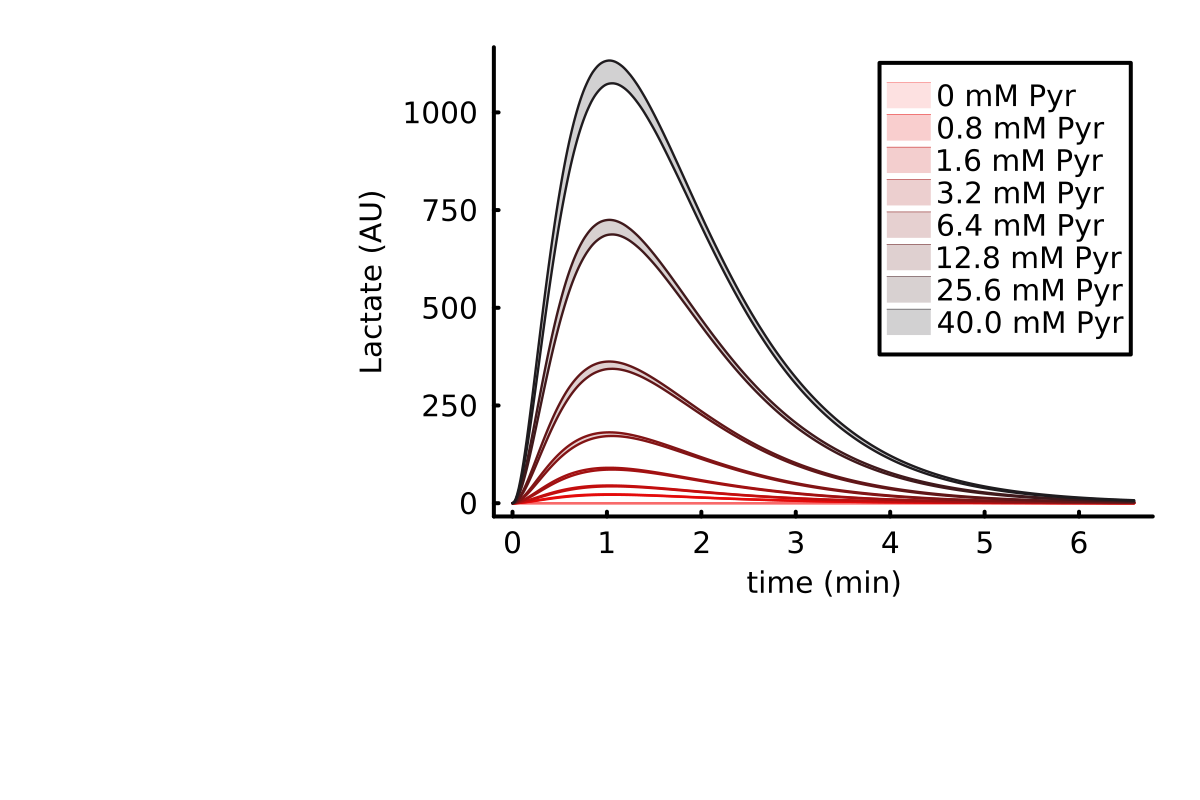

In [20]:
# Model With Transporter

i = 1
colpal = ["#f86a6aff", "#E40B0B", "#C30E0E", "#A21112", "#821415", "#611618", "#40191C", "#1F1C1F"];
po = plot(tsC2./60, PosterQuant[1,3,i], label = "", color = colpal[i],
  xlabel = "time (min)", ylabel = "Lactate (AU)", grid = false, markersize=1, markerstrokewidth=0.2, 
  linewidth=0.6, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5)
plot!(tsC2./60, PosterQuant[2,3,i], label = "", color = colpal[i], linewidth=0.6)
plot!(tsC2./60, PosterQuant[2,3,i], fillrange=PosterQuant[1,3,i], label=labs[i], color=colpal[i], fillalpha=0.2, linewidth=0)

for i in 2:length(PyrCons)
  plot!(tsC2./60, PosterQuant[1,3,i], label = "", color = colpal[i], linewidth = 0.6,
    xlabel = "time (min)", ylabel = "Lactate (AU)")
  plot!(tsC2./60, PosterQuant[2,3,i], label = "", color = colpal[i], linewidth = 0.6)
  plot!(tsC2./60, PosterQuant[2,3,i], fillrange=PosterQuant[1,3,i], label=labs[i], color=colpal[i], fillalpha=0.2, linewidth=0)
end



display(plot(po, size = (1200, 800)))


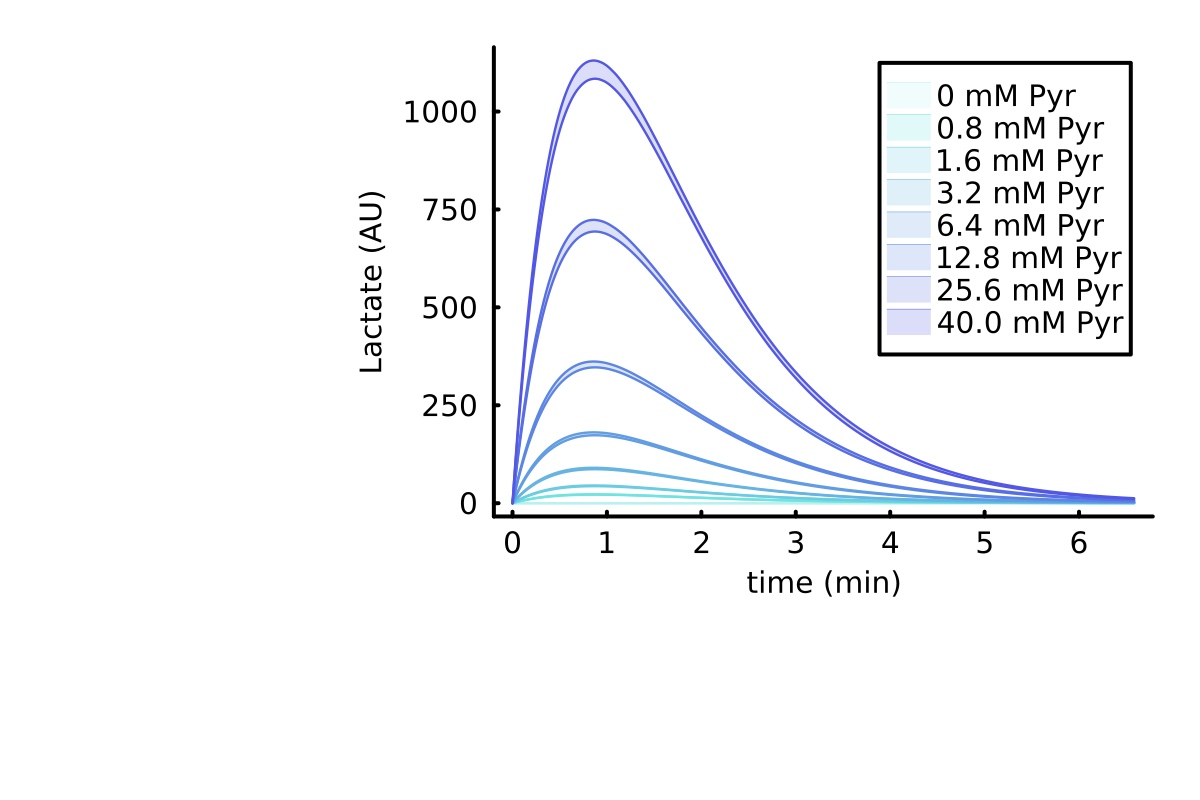

In [18]:
# Model W/O Transporter
colpal = ["#baf1f0ff", "#6FE3E1", "#6ACCE2", "#65B4E2", "#619DE3", "#5C86E4", "#576EE4", "#5257E5"]

i = 1
po = plot(tsC2./60, PosterQuantNT[1,2,i], label = "", color = colpal[i],
  xlabel = "time (min)", ylabel = "Lactate (AU)", grid = false, markersize=1, markerstrokewidth=0.2, 
  linewidth=0.6, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5)
plot!(tsC2./60, PosterQuantNT[2,2,i], label = "", color = colpal[i], linewidth=0.6)
plot!(tsC2./60, PosterQuantNT[2,2,i], fillrange=PosterQuantNT[1,2,i], label=labs[i], color=colpal[i], fillalpha=0.2, linewidth=0)

for i in 2:length(PyrCons)
  plot!(tsC2./60, PosterQuantNT[1,2,i], label = "", color = colpal[i], linewidth = 0.6,
    xlabel = "time (min)", ylabel = "Lactate (AU)")
  plot!(tsC2./60, PosterQuantNT[2,2,i], label = "", color = colpal[i], linewidth = 0.6)
  plot!(tsC2./60, PosterQuantNT[2,2,i], fillrange=PosterQuantNT[1,2,i], label=labs[i], color=colpal[i], fillalpha=0.2, linewidth=0)
end


display(plot(po, size = (1200, 800)))


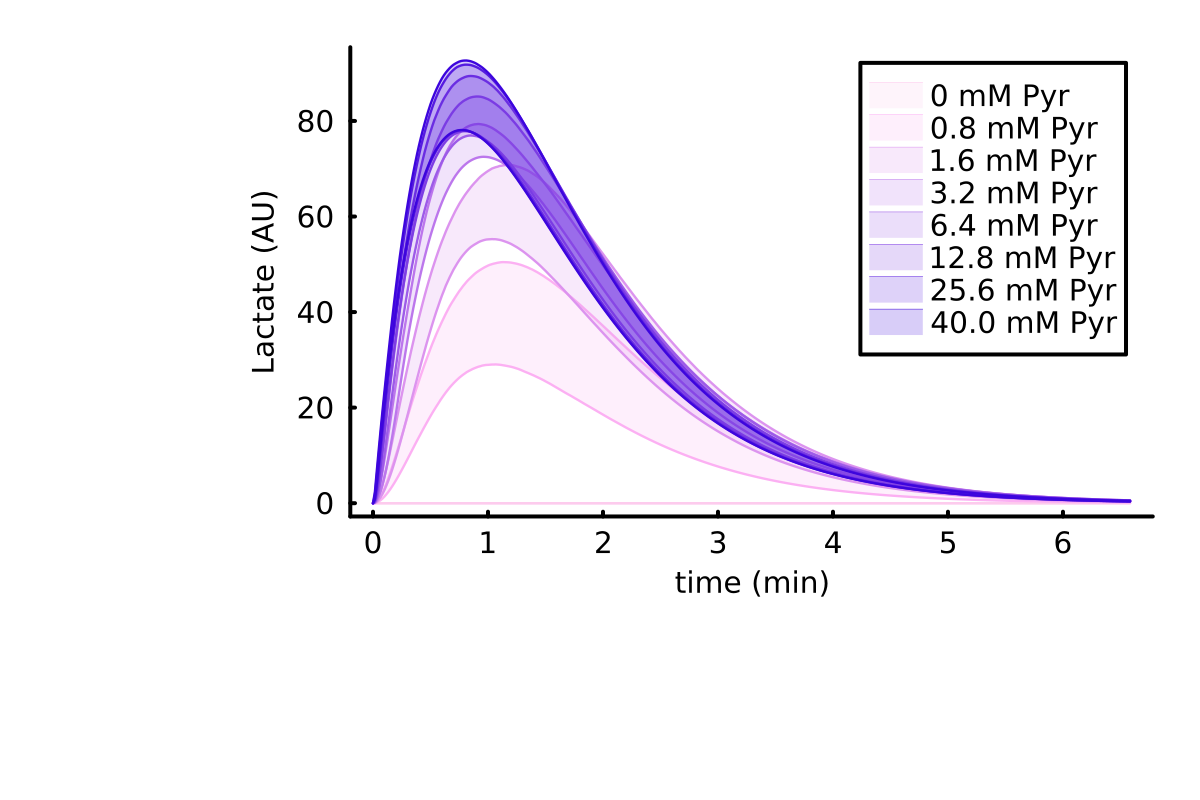

In [20]:
# Model Michaelis Menten

i = 1
colpal = ["#FF5800", "#FF7400", "#FF9000", "#FFAC00", "#FFC700", "#FFE300", "#FFFF00"];
colpal = ["#fdcbedff", "#FCB0F3", "#DC94EF", "#BC77EC", "#9D5BE8", "#7D3EE4", "#5D22E1", "#3D05DD"];

po = plot(tsC2./60, PosterQuantMM[1,5,i], label = "", color = colpal[i],
  xlabel = "time (min)", ylabel = "Lactate (AU)", grid = false, markersize=1, markerstrokewidth=0.2, 
  linewidth=0.6, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5)
plot!(tsC2./60, PosterQuantMM[2,5,i], label = "", color = colpal[i], linewidth=0.6)
plot!(tsC2./60, PosterQuantMM[2,5,i], fillrange=PosterQuantMM[1,5,i], label=labs[i], color=colpal[i], fillalpha=0.2, linewidth=0)

for i in 2:length(PyrCons)
  plot!(tsC2./60, PosterQuantMM[1,5,i], label = "", color = colpal[i], linewidth = 0.6,
    xlabel = "time (min)", ylabel = "Lactate (AU)")
  plot!(tsC2./60, PosterQuantMM[2,5,i], label = "", color = colpal[i], linewidth = 0.6)
  plot!(tsC2./60, PosterQuantMM[2,5,i], fillrange=PosterQuantMM[1,5,i], label=labs[i], color=colpal[i], fillalpha=0.2, linewidth=0)
end

plot(po, size = (1200, 800))

savefig("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\Paper\\Figures\\SuppFig11Stuff\\ModelPredictionsMMM.svg")

display(plot(po, size = (1200, 800)))


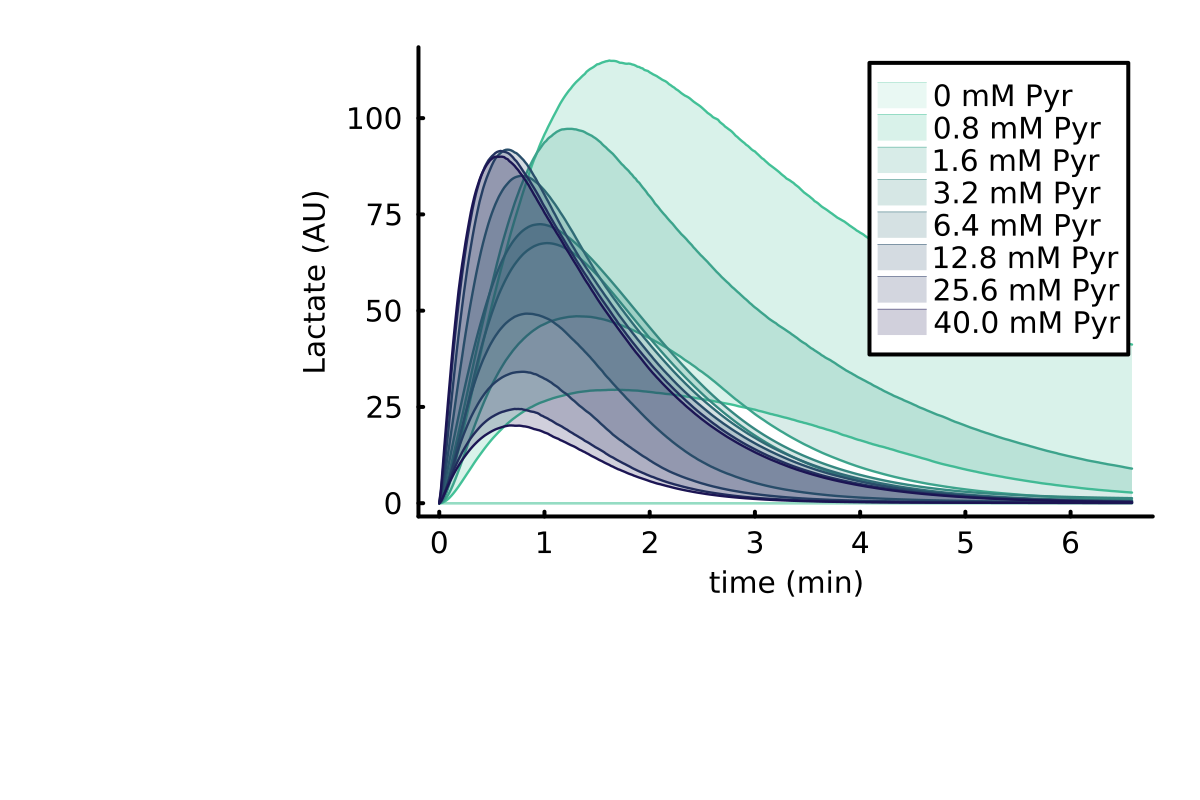

In [21]:
# Model With Competitive Repression

i = 1
colpal = ["#95dcc3ff", "#43C197", "#3DA48C", "#368881", "#306B76", "#294E6A", "#23325F", "#1C1554"];
po = plot(tsC2./60, PosterQuantCR[1,13,i], label = "", color = colpal[i],
  xlabel = "time (min)", ylabel = "Lactate (AU)", grid = false, markersize=1, markerstrokewidth=0.2, 
  linewidth=0.6, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5)
plot!(tsC2./60, PosterQuantCR[2,13,i], label = "", color = colpal[i], linewidth=0.6)
plot!(tsC2./60, PosterQuantCR[2,13,i], fillrange=PosterQuantCR[1,13,i], label=labs[i], color=colpal[i], fillalpha=0.2, linewidth=0)

for i in 2:length(PyrCons)
  plot!(tsC2./60, PosterQuantCR[1,13,i], label = "", color = colpal[i], linewidth = 0.6,
    xlabel = "time (min)", ylabel = "Lactate (AU)")
  plot!(tsC2./60, PosterQuantCR[2,13,i], label = "", color = colpal[i], linewidth = 0.6)
  plot!(tsC2./60, PosterQuantCR[2,13,i], fillrange=PosterQuantCR[1,13,i], label=labs[i], color=colpal[i], fillalpha=0.2, linewidth=0)
end



plot(po, size = (1200, 800))

savefig("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\Paper\\Figures\\SuppFig11Stuff\\ModelPredictionsMCR.svg")

display(plot(po, size = (1200, 800)))


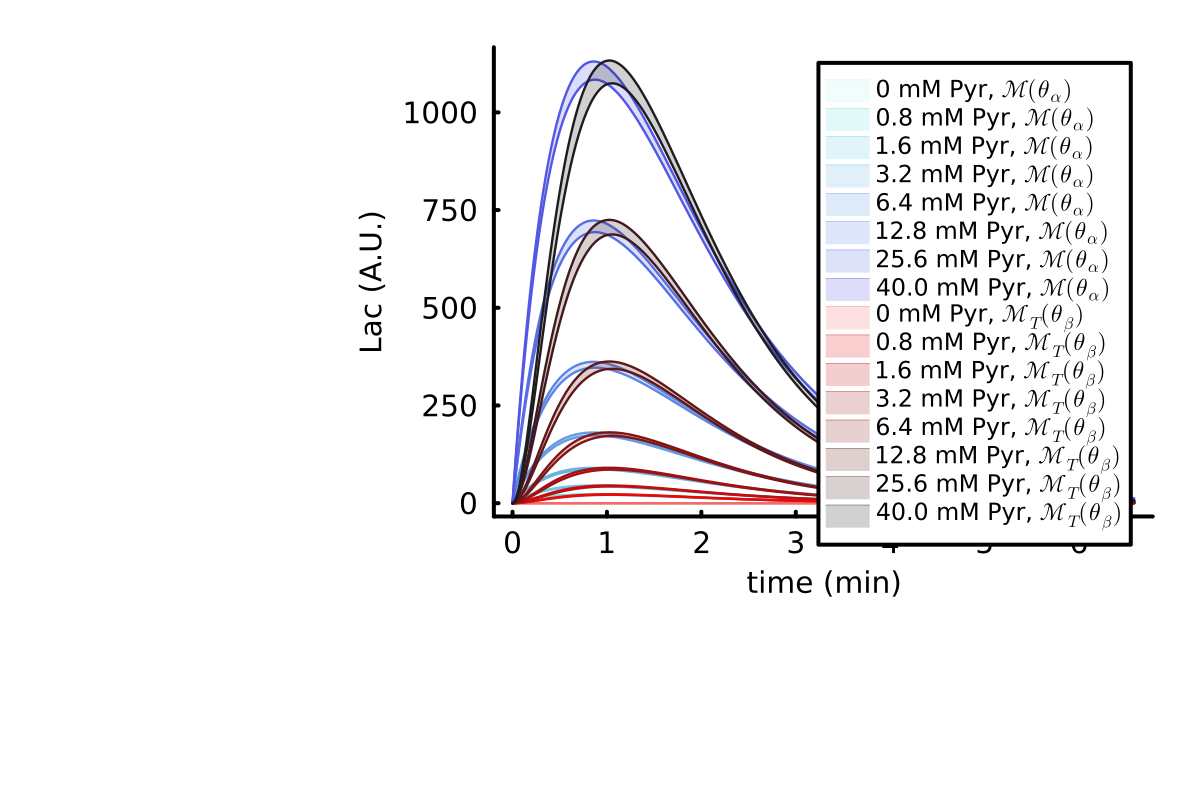

In [23]:
# Combo

colpal = ["#baf1f0ff", "#6FE3E1", "#6ACCE2", "#65B4E2", "#619DE3", "#5C86E4", "#576EE4", "#5257E5"]

i = 1
po = plot(tsC2./60, PosterQuantNT[1,2,i], label = "", color = colpal[i],
  xlabel = "time (min)", ylabel = "Lac (AU)", grid = false, markersize=1, markerstrokewidth=0.2, 
  linewidth=0.6, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5)
plot!(tsC2./60, PosterQuantNT[2,2,i], label = "", color = colpal[i], linewidth=0.6)
plot!(tsC2./60, PosterQuantNT[2,2,i], fillrange=PosterQuantNT[1,2,i], label=labs[i]*", "*L"\mathcal{M}(\theta_{\alpha})", color=colpal[i], fillalpha=0.2, linewidth=0)

for i in 2:length(PyrCons)
  plot!(tsC2./60, PosterQuantNT[1,2,i], label = "", color = colpal[i], linewidth = 0.6,
    xlabel = "time (min)", ylabel = "Lac (AU)")
  plot!(tsC2./60, PosterQuantNT[2,2,i], label = "", color = colpal[i], linewidth = 0.6)
  plot!(tsC2./60, PosterQuantNT[2,2,i], fillrange=PosterQuantNT[1,2,i], label=labs[i]*", "*L"\mathcal{M}(\theta_{\alpha})", color=colpal[i], fillalpha=0.2, linewidth=0)
end

i = 1
colpal = ["#f86a6aff", "#E40B0B", "#C30E0E", "#A21112", "#821415", "#611618", "#40191C", "#1F1C1F"];
plot!(tsC2./60, PosterQuant[1,3,i], label = "", color = colpal[i],
  xlabel = "time (min)", ylabel = "Lac (AU)", grid = false, markersize=1, markerstrokewidth=0.2, 
  linewidth=0.6, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=4)
plot!(tsC2./60, PosterQuant[2,3,i], label = "", color = colpal[i], linewidth=0.6)
plot!(tsC2./60, PosterQuant[2,3,i], fillrange=PosterQuant[1,3,i], label=labs[i]*", "*L"\mathcal{M}_{T}(\theta_{\beta})", color=colpal[i], fillalpha=0.2, linewidth=0)

for i in 2:length(PyrCons)
  plot!(tsC2./60, PosterQuant[1,3,i], label = "", color = colpal[i], linewidth = 0.6,
    xlabel = "time (min)", ylabel = "Lac (A.U.)")
  plot!(tsC2./60, PosterQuant[2,3,i], label = "", color = colpal[i], linewidth = 0.6)
  plot!(tsC2./60, PosterQuant[2,3,i], fillrange=PosterQuant[1,3,i], label=labs[i]*", "*L"\mathcal{M}_{T}(\theta_{\beta})", color=colpal[i], fillalpha=0.2, linewidth=0)
end


plot(po, size = (1200, 800))

savefig("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\Paper\\Figures\\Figure3Stuff\\SimulLacAllConc.svg")

display(plot(po, size = (1200, 800)))


## Test Trapz Package

In [21]:
PyrCons2 = [3.2];
ObsPyrCons2 = PyrCons2.*(1000*0.12*ScF);

tsC2_1 = dat2[1,1]:1:dat2[end,1]
tsC2_2 = dat2[1,1]:5:dat2[end,1]
tsC2_3 = dat2[1,1]:10:dat2[end,1]
tsC2_4 = vcat(0, 15:5:dat2[end,1])

ts1 = 0:tsC2_1[end];
ts2 = 0:tsC2_2[end];
ts3 = 0:tsC2_3[end];
ts4 = 0:tsC2_4[end];

ivss = [ObsPyrCons2[1], 0, dat2[1,4]];
samps1 = convert.(Int, tsC2_1);
samps2 = convert.(Int, tsC2_2);
samps3 = convert.(Int, tsC2_3);
samps4 = convert.(Int, tsC2_4);

SimOnTime1poster1, SimOffTime1poster1, SimAll1poster1  = PyruvateHP_NMR_SolveAllTb(ts1, hcat(mean(poster[:,1].*3), mean(poster[:,2].*3), mean(poster[:,4]), mean(poster[:,3]), mean(poster[:,end].*3), 0), ivss, samps1);
SimOnTime1poster2, SimOffTime1poster2, SimAll1poster2  = PyruvateHP_NMR_SolveAllTb(ts2, hcat(mean(poster[:,1].*3), mean(poster[:,2].*3), mean(poster[:,4]), mean(poster[:,3]), mean(poster[:,end].*3), 0), ivss, samps2);
SimOnTime1poster3, SimOffTime1poster3, SimAll1poster3  = PyruvateHP_NMR_SolveAllTb(ts3, hcat(mean(poster[:,1].*3), mean(poster[:,2].*3), mean(poster[:,4]), mean(poster[:,3]), mean(poster[:,end].*3), 0), ivss, samps3);
SimOnTime1poster4, SimOffTime1poster4, SimAll1poster4  = PyruvateHP_NMR_SolveAllTb(ts4, hcat(mean(poster[:,1].*3), mean(poster[:,2].*3), mean(poster[:,4]), mean(poster[:,3]), mean(poster[:,end].*3), 0), ivss, samps4);


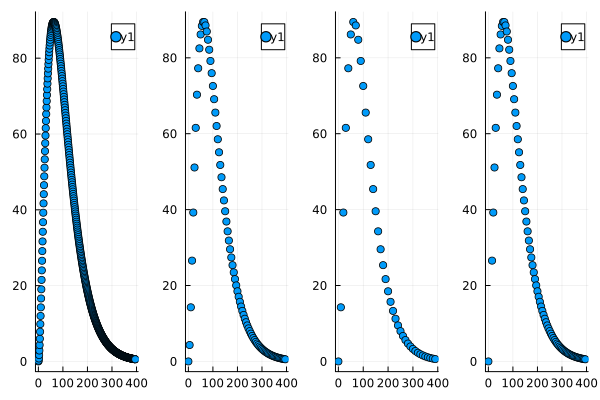

In [22]:
p1 = scatter(samps1, SimOnTime1poster1[:,3,1]); p2 = scatter(samps2, SimOnTime1poster2[:,3,1]); p3 = scatter(samps3, SimOnTime1poster3[:,3,1]); p4 = scatter(samps4, SimOnTime1poster4[:,3,1]);
plot(p1,p2,p3,p4, layout = (1,4))

In [23]:
println(trapz(samps1, SimOnTime1poster1[:,3,1]))
println(trapz(samps2, SimOnTime1poster2[:,3,1]))
println(trapz(samps3, SimOnTime1poster3[:,3,1]))
println(trapz(samps4, SimOnTime1poster4[:,3,1]))

11784.694752263715
11784.630081579715
11780.953457096848
11824.525474928632


## Simulate Experiments To Show Data Against Pyruvate Concentration

In [24]:
# Transporter
PyrCons2 = collect(0.01:0.1:40);
ObsPyrCons2 = PyrCons2.*(1000*0.12*ScF);

tsC2 = dat2[1,1]:1:dat2[end,1]
ts = 0:tsC2[end];

posterSims2 = Array{Any}(undef, length(PyrCons2))
for i in 1:length(PyrCons2)
    ivss = [ObsPyrCons2[i], 0, dat2[1,4]];
    samps = convert.(Int, tsC2);
    SimOnTime1poster, SimOffTime1poster, SimAll1poster  = PyruvateHP_NMR_SolveAllTb(ts, hcat(mean(poster[:,1].*3), mean(poster[:,2].*3), mean(poster[:,4]), mean(poster[:,3]), mean(poster[:,end].*3), 0), ivss, samps);

    posterSims2[i] = SimOnTime1poster;
end

In [25]:
# No trasnporter
posterSims2NT = Array{Any}(undef, length(PyrCons2))
for i in 1:length(PyrCons2)
    ivss = [ObsPyrCons2[i], dat2[1,4]];
    samps = convert.(Int, tsC2);
    SimOnTime1poster, SimOffTime1poster, SimAll1poster  = PyruvateHP_NMR_SolveAll(ts, mean(hcat(posterNT[:,1:2].*3, posterNT[:,4], posterNT[:,3], zeros(8000)), dims=1), ivss, samps);

    posterSims2NT[i] = SimOnTime1poster;
end

In [26]:
# Michaelis Menten
posterSims2MM = Array{Any}(undef, length(PyrCons2))
for i in 1:length(PyrCons2)
    ivss = [ObsPyrCons2[i], 0, mean(posterMM[:,end]).*0.75, 0, 0];
    samps = convert.(Int, tsC2);
    SimOnTime1poster, SimOffTime1poster, SimAll1poster  = PyruvateHP_NMR_SolveAllMM(ts, mean(hcat(posterMM[:,1]*0.75, posterMM[:,2:6], zeros(8000)), dims=1), ivss, samps);

    posterSims2MM[i] = SimOnTime1poster;
end

In [27]:
# Competitive Repression
posterSims2CR = Array{Any}(undef, length(PyrCons2))
for i in 1:length(PyrCons2)
    ivss = [PyrCons2[i].*1000, 0, 0, mean(posterCR[:,end-2]), mean(posterCR[:,end-1]), mean(posterCR[:,end]), 0, 0, 0, 0, 0, PyrCons2[i].*1000, 0, PyrCons2[i].*(1000*0.12*posterCR[1,end-3])];
    samps = convert.(Int, tsC2);
    SimOnTime1poster, SimOffTime1poster, SimAll1poster  = PyruvateHP_NMR_SolveAllCp(ts, mean(hcat(posterCR[:,1:end-3], zeros(8000)), dims=1), ivss, samps);

    posterSims2CR[i] = SimOnTime1poster;
end

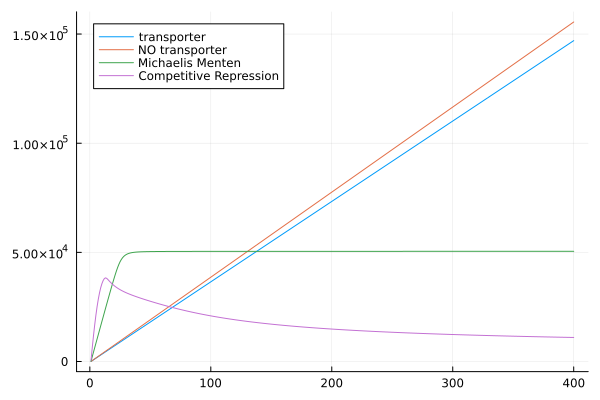

In [28]:
i = 1

plot([sum(posterSims2[i][:,3,1]) for i in 1:length(ObsPyrCons2)], label = "transporter")
plot!([sum(posterSims2NT[i][:,2,1]) for i in 1:length(ObsPyrCons2)], label = "NO transporter")
plot!([sum(posterSims2MM[i][:,5,1]) for i in 1:length(ObsPyrCons2)], label = "Michaelis Menten")
plot!([sum(posterSims2CR[i][:,13,1]) for i in 1:length(ObsPyrCons2)], label = "Competitive Repression")

In [44]:
# sum(posterSims2[i][:,3,:]./(1000*0.12*ScF), dims = 1)

In [45]:
# plot([sum(posterSims2[i][:,3,1]./(1000*0.12*ScF)) for i in 1:length(ObsPyrCons2)])

# plot!([sum(posterSims2[i][:,3,1])./(1000*0.12*ScF) for i in 1:length(ObsPyrCons2)])

In [92]:
ScF

23.899724568420652

In [29]:
# Model With Transporter

PyrCons3 = collect(0.01:0.1:40);
ObsPyrCons3 = PyrCons3.*(1000*0.12*ScF);

tsC2 = dat2[1,1]:1:dat2[end,1]
ts = 0:tsC2[end];
samps = convert.(Int, tsC2);

Random.seed!(65464)
poster2 = poster[sample(1:8000, 400, replace = false),:];


# posterSims2 = Array{Any}(undef, length(PyrCons3))
# for i in 1:length(PyrCons3)
#     ivss = [ObsPyrCons3[i], 0, dat2[1,4]];
#     samps = convert.(Int, tsC2);
#     SimOnTime1poster, SimOffTime1poster, SimAll1poster  = PyruvateHP_NMR_SolveAllTb(ts, hcat(poster2[:,1].*2.5, poster2[:,2].*2.5, poster2[:,4], poster2[:,3], poster2[:,end].*2.5, zeros(400)), ivss, samps);

#     posterSims2[i] = SimOnTime1poster;
# end

400×5 Matrix{Float64}:
 0.0105415   0.00710795  51.2659  41.3918  0.000462251
 0.010039    0.00788126  51.2014  41.6031  0.000493908
 0.0128895   0.00574418  51.1008  41.5522  0.000394495
 0.0115161   0.00586512  51.0296  42.5863  0.000406674
 0.0139778   0.00593322  51.0529  42.9499  0.000371443
 0.0125147   0.00583639  51.1724  42.1622  0.00039926
 0.0110336   0.00664393  51.2085  40.4363  0.00045212
 0.00924985  0.0066031   51.5779  38.4541  0.000504755
 0.0134024   0.00494543  51.1841  41.6309  0.000376424
 0.00969418  0.00707013  51.497   39.2221  0.000505864
 ⋮                                         
 0.0107231   0.00676663  51.094   41.1506  0.00045388
 0.0124176   0.00618149  51.4105  40.4838  0.000411553
 0.0140732   0.00476561  51.0823  42.358   0.000358445
 0.0107482   0.00760208  50.9433  41.5436  0.00047383
 0.0132349   0.00660124  50.8667  43.2551  0.000390505
 0.0122706   0.00643157  51.5331  40.3214  0.000422408
 0.0132178   0.00638525  51.2601  41.4434  0.000401506
 0

In [30]:
# Model W/O Transporter
Random.seed!(65464)
posterNT2 = posterNT[sample(1:8000, 400, replace = false),:];

# posterSimsNT2 = Array{Any}(undef, length(PyrCons3))
# for i in 1:length(PyrCons3)
#     ivss = [ObsPyrCons3[i], dat2[1,4]];
#     samps = convert.(Int, tsC2);
#     SimOnTime1poster, SimOffTime1poster, SimAll1poster  = PyruvateHP_NMR_SolveAll(ts, hcat(posterNT2[:,1:2].*2.5, posterNT2[:,4], posterNT2[:,3], zeros(400)), ivss, samps);

#     posterSimsNT2[i] = SimOnTime1poster;
# end

400×4 Matrix{Float64}:
 0.000167139  5.38668e-6  50.0408  55.5342
 0.000167341  2.70169e-6  50.0499  55.8639
 0.000167308  6.48576e-7  50.1084  55.4187
 0.00016779   1.10109e-6  50.0827  55.6517
 0.000170794  5.68054e-7  50.0839  54.8069
 0.000164315  9.02783e-6  49.8648  56.283
 0.000164361  3.4021e-7   49.9775  56.4808
 0.00016602   6.05664e-6  50.0838  56.0594
 0.000167807  3.26691e-6  50.0506  55.0259
 0.000167055  2.47606e-7  50.1231  55.3769
 ⋮                                 
 0.000168506  4.92179e-8  50.0402  54.9974
 0.000168758  1.25854e-7  50.0589  55.0584
 0.000168241  6.37755e-7  50.0983  55.206
 0.000170711  3.95173e-6  50.0336  54.6733
 0.000171656  1.28907e-6  50.153   54.8107
 0.000165238  1.14417e-5  50.0105  56.6449
 0.000171835  2.50699e-6  50.1888  54.3511
 0.000169252  5.86167e-7  49.9946  55.7138
 0.000167375  2.53417e-7  50.0773  55.5141

In [31]:
# Model Michaelis Menten

PyrCons4 = collect(0.01:0.1:40);
ObsPyrCons4 = PyrCons4.*(1000*0.12*ScF);

tsC2 = dat2[1,1]:1:dat2[end,1]
ts = 0:tsC2[end];
samps = convert.(Int, tsC2);

Random.seed!(65464)
poster3 = posterMM[sample(1:8000, 400, replace = false),:];


# posterSims3 = Array{Any}(undef, length(PyrCons4))
# for i in 1:length(PyrCons4)
#     tmp = zeros(length(samps),5,400);
#     for j in 1:400
#         ivss = [ObsPyrCons4[i], 0, poster3[j,end].*0.625, 0, 0];
#         SimOnTime1poster, SimOffTime1poster, SimAll1poster  = PyruvateHP_NMR_SolveAllMM(ts, vcat(poster3[j,1].*0.625, poster3[j,2:6], zeros(1)), ivss, samps);
#         tmp[:,:,j] = SimOnTime1poster[:,:,1]
#     end

#     posterSims3[i] = tmp;
# end

400×7 Matrix{Float64}:
 0.00187932  0.0286396    0.783893  0.183051    51.0  41.0   36.7634
 0.0162092   0.00139017   0.69797   0.0416136   51.0  41.0  172.057
 0.0059748   0.221713     0.482943  0.00865369  51.0  41.0  722.116
 0.00556922  0.00391947   0.456498  0.109196    51.0  41.0   60.8432
 0.00192832  0.0387482    0.978441  0.161633    51.0  41.0   40.2001
 0.00728202  0.225368     0.788296  0.00750678  51.0  41.0  858.872
 0.00460107  0.391924     0.912043  0.0122877   51.0  41.0  517.483
 0.00599145  0.0125208    0.967585  0.0198934   51.0  41.0  333.774
 0.00593243  0.00865961   0.303918  0.0169688   51.0  41.0  369.618
 0.00627569  0.015272     0.537361  0.0114605   51.0  41.0  555.692
 ⋮                                                     ⋮    
 0.0103292   0.00181235   0.488357  0.0835219   51.0  41.0   82.1104
 0.0195159   0.000675675  0.347704  0.0495331   51.0  41.0  148.42
 0.0103063   0.00507736   0.745238  0.978472    51.0  41.0    6.94173
 0.00158165  0.0354952    0

23.8997

In [32]:
# Competitive Repression

PyrCons4 = collect(0.01:0.1:40);
ObsPyrCons4 = PyrCons4.*(1000*0.12*posterCR[1,end-3]);

tsC2 = dat2[1,1]:1:dat2[end,1]
ts = 0:tsC2[end];
samps = convert.(Int, tsC2);

Random.seed!(65464)
poster4 = posterCR[sample(1:8000, 400, replace = false),:];


# posterSims4 = Array{Any}(undef, length(PyrCons4))
# for i in 1:length(PyrCons4)
#     tmp = zeros(length(samps),14,400);
#     for j in 1:400
#         ivss = [ObsPyrCons4[i], 0, poster4[j,end].*0.75, 0, 0];
#         ivss = [PyrCons4[i].*1000, 0, 0, poster4[j,end-2], poster4[j,end-1], poster4[j,end], 0, 0, 0, 0, 0, PyrCons4[i].*1000, 0, PyrCons4[i].*(1000*0.12*poster4[1,end-3])];
#         SimOnTime1poster, SimOffTime1poster, SimAll1poster  = PyruvateHP_NMR_SolveAllCp(ts, vcat(poster4[j,1:end-3], zeros(1)), ivss, samps);
#         tmp[:,:,j] = SimOnTime1poster[:,:,1]
#     end

#     posterSims4[i] = tmp;
# end

400×16 Matrix{Float64}:
 41.2614  51.23  0.001582    0.0892869  …   111.868   10285.0    597.952
 41.3422  51.23  0.00905945  0.0183953      845.089    9904.12   555.113
 31.1803  51.23  0.00162477  0.086759       220.639   15323.1    493.691
 40.8669  51.23  0.0018893   0.0489654       81.9347  16515.9    851.798
 47.5583  51.23  0.00328352  0.0343961      317.007   14264.3    470.842
 39.9781  51.23  0.00286716  0.0219679  …  1160.65    24171.7     64.254
 45.6655  51.23  0.00627453  0.0226466       95.9039  10776.3   1005.21
 48.9477  51.23  0.00415347  0.0295968      405.1      6654.52   871.84
 34.4668  51.23  0.00215825  0.0320109      122.793   26646.8    593.507
 47.2479  51.23  0.00514559  0.0224735      607.088   15340.7    524.989
  ⋮                                     ⋱                          ⋮
 39.0846  51.23  0.004929    0.0222097      102.645    9322.26   809.142
 52.2489  51.23  0.00644623  0.0448092     1018.26    23385.5    632.919
 44.0705  51.23  0.00445656  0.02

In [98]:
# JLD2.save("SimulationsTransportDiffPyrConcBayes.jld", "posterSims2", posterSims2)
# JLD2.save("SimulationsTransportDiffPyrConcBayesNT.jld", "posterSimsNT2", posterSimsNT2)
# JLD2.save("SimulationsTransportDiffPyrConcBayesMM.jld", "posterSims3", posterSims3)
# JLD2.save("SimulationsCompetRepresDiffPyrConcBayesMM.jld", "posterSims4", posterSims4)

In [33]:
posterSims2 = JLD2.load("SimulationsTransportDiffPyrConcBayes.jld")["posterSims2"];
posterSimsNT2 = JLD2.load("SimulationsTransportDiffPyrConcBayesNT.jld")["posterSimsNT2"];
posterSims3 = JLD2.load("SimulationsTransportDiffPyrConcBayesMM.jld")["posterSims3"];
posterSims4 = JLD2.load("SimulationsCompetRepresDiffPyrConcBayesMM.jld")["posterSims4"];

In [49]:
# # Model With Transporter
# sumSims = zeros(400, length(ObsPyrCons3));
# [sumSims[:,i] = sum(posterSims2[i][:,3,:]./(1000*0.12*ScF), dims = 1) for i in 1:length(ObsPyrCons3)];

# # Model W/O Transporter
# sumSimsNT = zeros(400, length(ObsPyrCons3));
# [sumSimsNT[:,i] = sum(posterSimsNT2[i][:,2,:]./(1000*0.12*ScF), dims = 1) for i in 1:length(ObsPyrCons3)];

In [34]:
# Model With Transporter
sumSims = zeros(400, length(ObsPyrCons3));
[sumSims[j,i] = trapz(samps, posterSims2[i][:,3,j]) for i in 1:length(ObsPyrCons3) for j in 1:400];

# Model W/O Transporter
sumSimsNT = zeros(400, length(ObsPyrCons3));
[sumSimsNT[j,i] = trapz(samps, posterSimsNT2[i][:,2,j]) for i in 1:length(ObsPyrCons3) for j in 1:400];

# Model Michaelis Menten
sumSimsMM = zeros(400, length(ObsPyrCons3));
[sumSimsMM[j,i] = trapz(samps, posterSims3[i][:,5,j]) for i in 1:length(ObsPyrCons3) for j in 1:400];

# Competitive Repression
sumSimsCR = zeros(400, length(ObsPyrCons3));
[sumSimsCR[j,i] = trapz(samps, posterSims4[i][:,13,j]) for i in 1:length(ObsPyrCons3) for j in 1:400];

In [35]:
mean(poster[:,3:end], dims = 1)

1×3 Matrix{Float64}:
 51.2374  40.9222  0.000434518

In [36]:
# Model With Transporter
# Dims = Up/Down, Observable, Experiment
lacSumQuant = Array{Any}(undef,2,length(PyrCons3));

for m in 1:length(PyrCons3)
    lacSumQuant[1,m] = percentile(sumSims[:,m], 99.5); # Up
    lacSumQuant[2,m] = percentile(sumSims[:,m], 0.5 ); # Down
end

# Model W/O Transporter
lacSumQuantNT = Array{Any}(undef,2,length(PyrCons3));

for m in 1:length(PyrCons3)
    lacSumQuantNT[1,m] = percentile(sumSimsNT[:,m], 99.5); # Up
    lacSumQuantNT[2,m] = percentile(sumSimsNT[:,m], 0.5 ); # Down
end

# Michaelis Menten
lacSumQuantMM = Array{Any}(undef,2,length(PyrCons3));

for m in 1:length(PyrCons3)
    lacSumQuantMM[1,m] = percentile(sumSimsMM[:,m], 95); # Up
    lacSumQuantMM[2,m] = percentile(sumSimsMM[:,m], 5 ); # Down
end

# Competitive Repression
lacSumQuantCR = Array{Any}(undef,2,length(PyrCons3));

for m in 1:length(PyrCons3)
    lacSumQuantCR[1,m] = percentile(sumSimsCR[:,m], 95); # Up
    lacSumQuantCR[2,m] = percentile(sumSimsCR[:,m], 5 ); # Down
end

In [37]:
ccpal = ["#0D3B66","#FAF0CA","#F4D35E"];
ccpal = ["#EDAE49","#D1495B","#00798C"];
ccpal = ["#F4F1BB","#ED6A5A","#9BC1BC"];
ccpal = ["#26547C","#00806bff","#FFD166","#EF476F"];
ccpal = ["#26547cff","#ef476fff","#ffd166ff","#00806bff"];
# ccpal = ["#","#","#"];
# ccpal = ["#","#","#"];


4-element Vector{String}:
 "#26547cff"
 "#ef476fff"
 "#ffd166ff"
 "#00806bff"

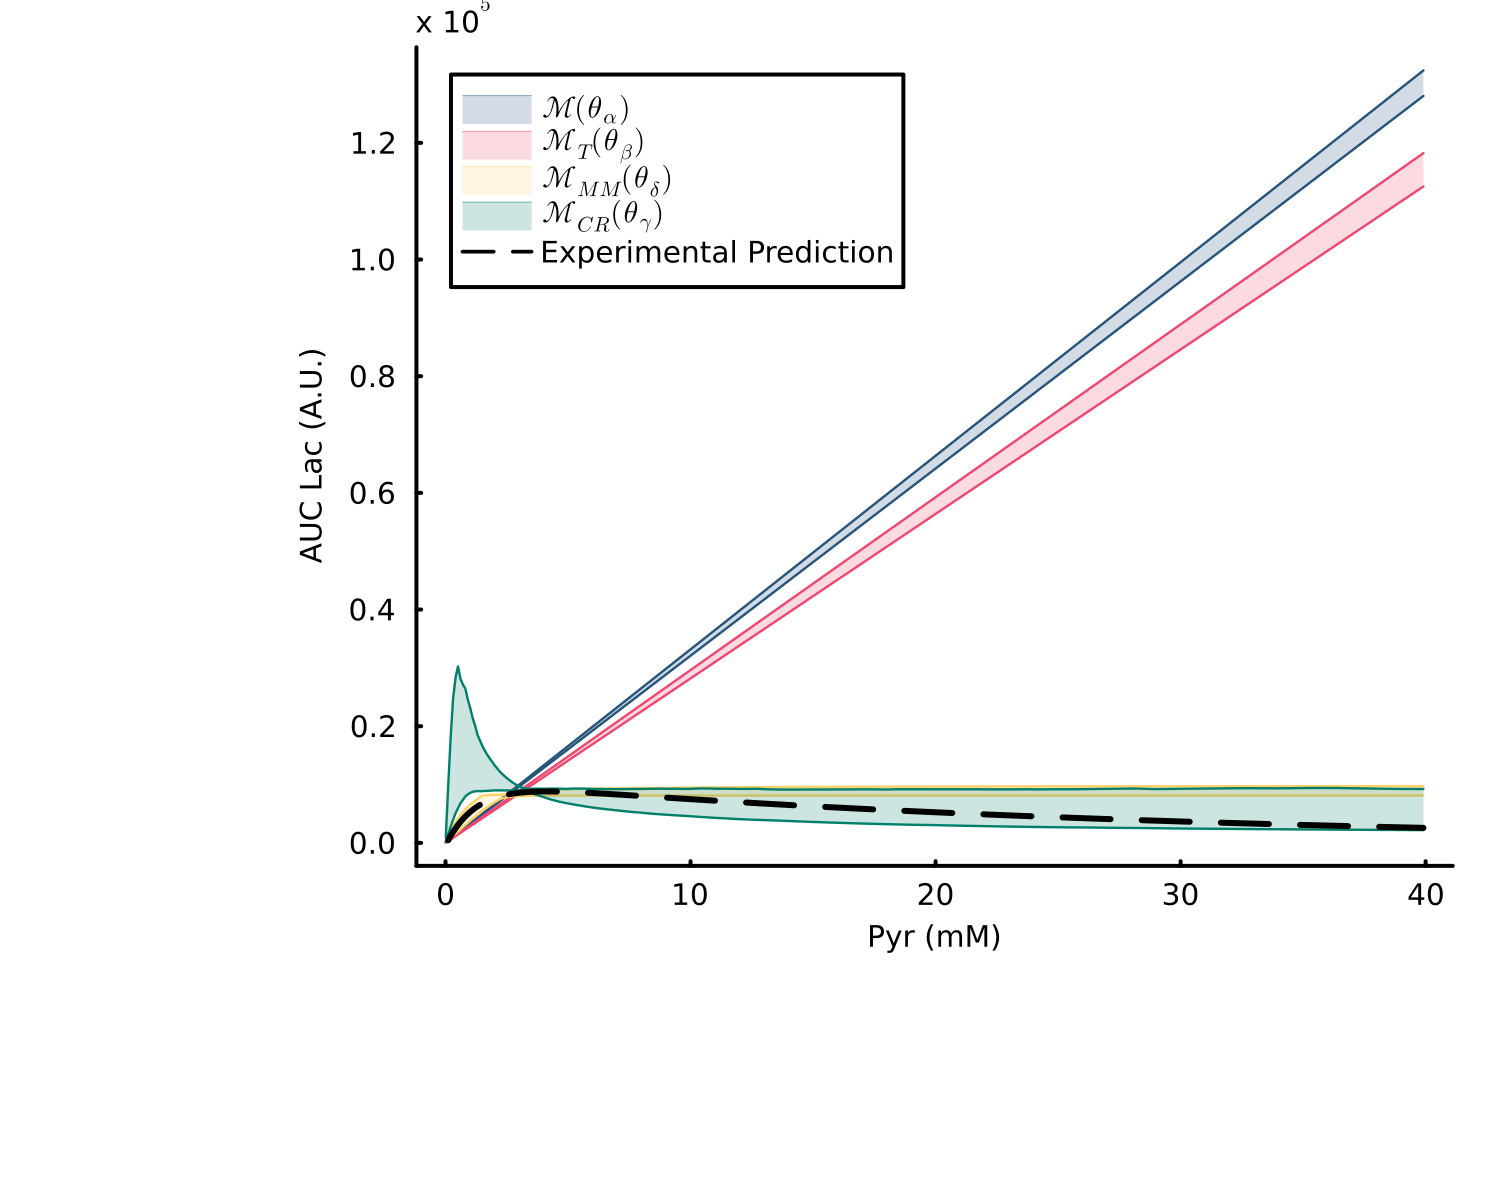

In [38]:
po2 = plot(PyrCons3, lacSumQuantNT[1,:]./10^5, label = "", color = ccpal[1],
xlabel = "Pyr (mM)", ylabel = "AUC Lac (A.U.)", grid = false, markersize=1, markerstrokewidth=0.2, 
linewidth=0.6, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5)
plot!(PyrCons3, lacSumQuantNT[2,:]./10^5, label = "", color = ccpal[1], linewidth=0.6)
plot!(PyrCons3, lacSumQuantNT[2,:]./10^5, fillrange=convert.(Float64, lacSumQuantNT[1,:]./10^5), color=ccpal[1], fillalpha=0.2, linewidth = 0, label = L"\mathcal{M}(\theta_{\alpha})")

# -------------------------------------------------------------------------------------

plot!(PyrCons3, lacSumQuant[1,:]./10^5, label = "", color = ccpal[2],
  xlabel = "Pyr (mM)", ylabel = "AUC Lac (A.U.)", grid = false, markersize=1, markerstrokewidth=0.2, 
  linewidth=0.6, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5)
plot!(PyrCons3, lacSumQuant[2,:]./10^5, label = "", color = ccpal[2], linewidth=0.6)
plot!(PyrCons3, lacSumQuant[2,:]./10^5, fillrange=convert.(Float64, lacSumQuant[1,:]./10^5), color=ccpal[2], fillalpha=0.2, linewidth = 0, label = L"\mathcal{M}_{T}(\theta_{\beta})")


annotate!(-1.2, 1.42, text("x 10"*L"^5", :black, :left, 5))

# # -------------------------------------------------------------------------------------

plot!(PyrCons3, lacSumQuantMM[1,:]./10^5, label = "", color = ccpal[3],
  xlabel = "Pyr (mM)", ylabel = "AUC Lac (A.U.)", grid = false, markersize=1, markerstrokewidth=0.2, 
  linewidth=0.6, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5)
plot!(PyrCons3, lacSumQuantMM[2,:]./10^5, label = "", color = ccpal[3], linewidth=0.6)
plot!(PyrCons3, lacSumQuantMM[2,:]./10^5, fillrange=convert.(Float64, lacSumQuantMM[1,:]./10^5), color=ccpal[3], fillalpha=0.2, linewidth = 0, label = L"\mathcal{M}_{MM}(\theta_{\delta})")


# plot!(PyrCons3, mean(sumSimsMM[1,:], dims = 2)./10^5)

# MM(Vmax, KM, Pyr) = (Vmax.*Pyr)./(KM .+ Pyr)
# plot!(PyrCons3, MM(30, 3.2, PyrCons3), label = "")


# # -------------------------------------------------------------------------------------

plot!(PyrCons3, lacSumQuantCR[1,:]./10^5, label = "", color = ccpal[4],
  xlabel = "Pyr (mM)", ylabel = "AUC Lac (A.U.)", grid = false, markersize=1, markerstrokewidth=0.2, 
  linewidth=0.6, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5)
plot!(PyrCons3, lacSumQuantCR[2,:]./10^5, label = "", color = ccpal[4], linewidth=0.6)
plot!(PyrCons3, lacSumQuantCR[2,:]./10^5, fillrange=convert.(Float64, lacSumQuantCR[1,:]./10^5), color=ccpal[4], fillalpha=0.2, linewidth = 0, label = L"\mathcal{M}_{CR}(\theta_{\gamma})")



# # -------------------------------------------------------------------------------------




  
    
 
    

pp = [71.52456846326336, 149.72936537382074, 0.035641505051707635, -155.7168946583787, 0.7919342251656567]
ss(t,p) = p[1].*(p[2].*exp.(-t.*p[3]).+p[4].*exp.(-t.*p[5]))
oblcrl = ss(PyrCons3, pp)./10^5;
plot!(PyrCons3[oblcrl.>0], oblcrl[oblcrl.>0], label = "Experimental Prediction", markersize=1, markerstrokewidth=0.2, 
linewidth=1.5, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5,
colour = "black", linestyle = :dash)


# display(po2)

# savefig(po2,"C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\Paper\\Figures\\Figure3Stuff\\AllModelPredictions.svg")

display(po2)

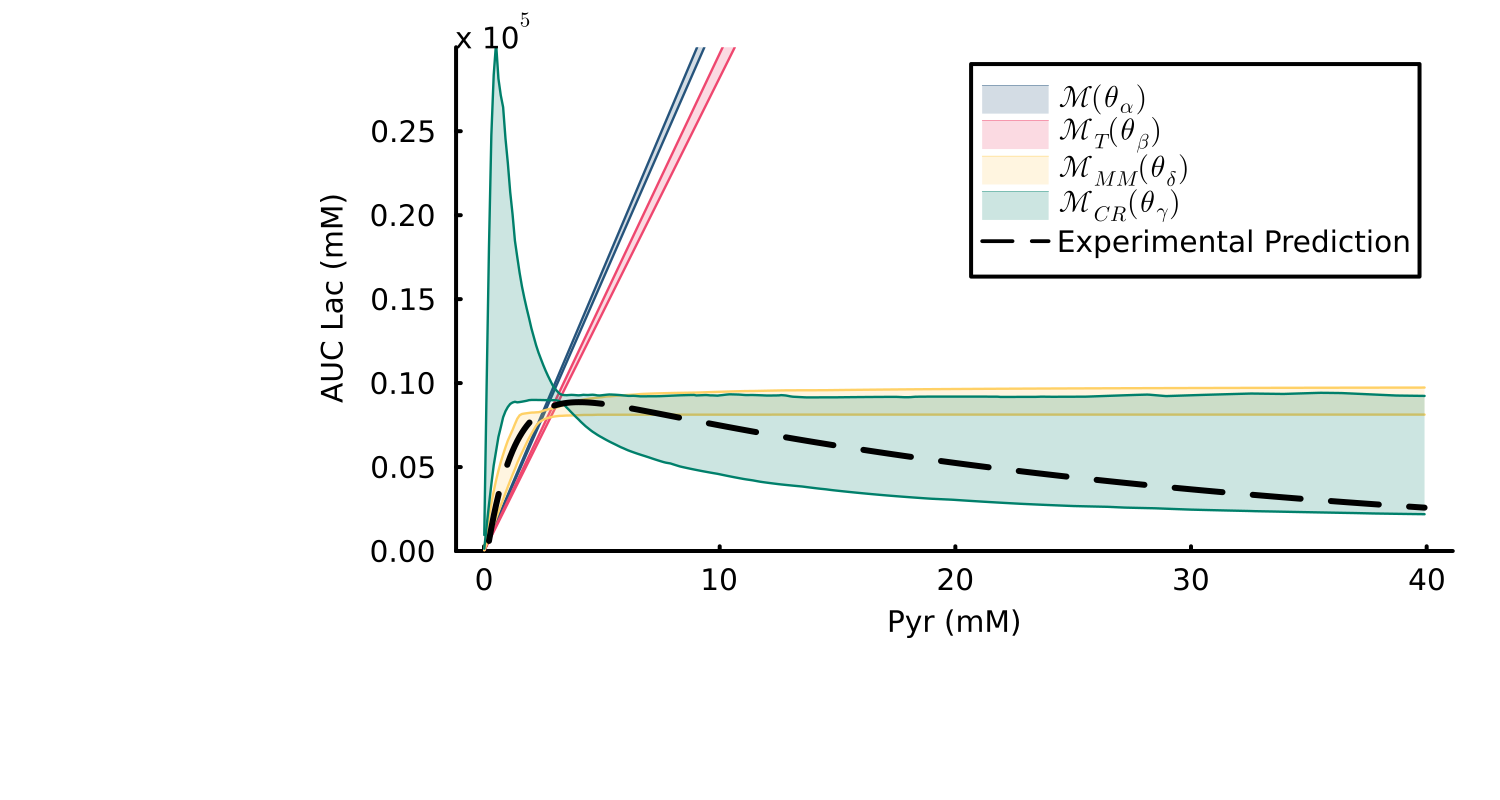

In [46]:
o2 = plot(PyrCons3, lacSumQuantNT[1,:]./10^5, label = "", color = ccpal[1],
xlabel = "Pyr (mM)", ylabel = "AUC Lac (mM)", grid = false, markersize=1, markerstrokewidth=0.2, 
linewidth=0.6, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5)
plot!(PyrCons3, lacSumQuantNT[2,:]./10^5, label = "", color = ccpal[1], linewidth=0.6)
plot!(PyrCons3, lacSumQuantNT[2,:]./10^5, fillrange=convert.(Float64, lacSumQuantNT[1,:]./10^5), color=ccpal[1], fillalpha=0.2, linewidth = 0, label = L"\mathcal{M}(\theta_{\alpha})")

# -------------------------------------------------------------------------------------

plot!(PyrCons3, lacSumQuant[1,:]./10^5, label = "", color = ccpal[2],
  xlabel = "Pyr (mM)", ylabel = "AUC Lac (mM)", grid = false, markersize=1, markerstrokewidth=0.2, 
  linewidth=0.6, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5)
plot!(PyrCons3, lacSumQuant[2,:]./10^5, label = "", color = ccpal[2], linewidth=0.6)
plot!(PyrCons3, lacSumQuant[2,:]./10^5, fillrange=convert.(Float64, lacSumQuant[1,:]./10^5), color=ccpal[2], fillalpha=0.2, linewidth = 0, label = L"\mathcal{M}_{T}(\theta_{\beta})")



# -------------------------------------------------------------------------------------

plot!(PyrCons3, lacSumQuantMM[1,:]./10^5, label = "", color = ccpal[3],
  xlabel = "Pyr (mM)", ylabel = "AUC Lac (mM)", grid = false, markersize=1, markerstrokewidth=0.2, 
  linewidth=0.6, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5)
plot!(PyrCons3, lacSumQuantMM[2,:]./10^5, label = "", color = ccpal[3], linewidth=0.6)
plot!(PyrCons3, lacSumQuantMM[2,:]./10^5, fillrange=convert.(Float64, lacSumQuantMM[1,:]./10^5), color=ccpal[3], fillalpha=0.2, linewidth = 0, label = L"\mathcal{M}_{MM}(\theta_{\delta})")


# MM(Vmax, KM, Pyr) = (Vmax.*Pyr)./(KM .+ Pyr)
# plot!(PyrCons3, MM(30, 3.2, PyrCons3), label = "")

# # -------------------------------------------------------------------------------------

plot!(PyrCons3, lacSumQuantCR[1,:]./10^5, label = "", color = ccpal[4],
  xlabel = "Pyr (mM)", ylabel = "AUC Lac (mM)", grid = false, markersize=1, markerstrokewidth=0.2, 
  linewidth=0.6, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5)
plot!(PyrCons3, lacSumQuantCR[2,:]./10^5, label = "", color = ccpal[4], linewidth=0.6)
plot!(PyrCons3, lacSumQuantCR[2,:]./10^5, fillrange=convert.(Float64, lacSumQuantCR[1,:]./10^5), color=ccpal[4], fillalpha=0.2, linewidth = 0, label = L"\mathcal{M}_{CR}(\theta_{\gamma})")



# # -------------------------------------------------------------------------------------





pp = [74.03725788756323, 144.2284171571619, 0.035560077190086616, -161.44232064449685, 0.8504800680532763]
ss(t,p) = p[1].*(p[2].*exp.(-t.*p[3]).+p[4].*exp.(-t.*p[5]))
oblcrl = ss(PyrCons3, pp)./10^5;
plot!(PyrCons3[oblcrl.>0], oblcrl[oblcrl.>0], label = "Experimental Prediction", markersize=1, markerstrokewidth=0.2, 
linewidth=1.5, size = (1500,800), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5,
colour = "black", linestyle = :dash, ylim = [0,0.3])


# scatter!([2.8],[8.5], label = "")

annotate!(-1.2, 0.31, text("x 10"*L"^5", :black, :left, 5))


# savefig(o2,"C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\Paper\\Figures\\Figure3Stuff\\AllModelPredictionsZoom.svg")

display(o2)

In [44]:
xlims(o2)

(-1.1870000000000047, 41.107)

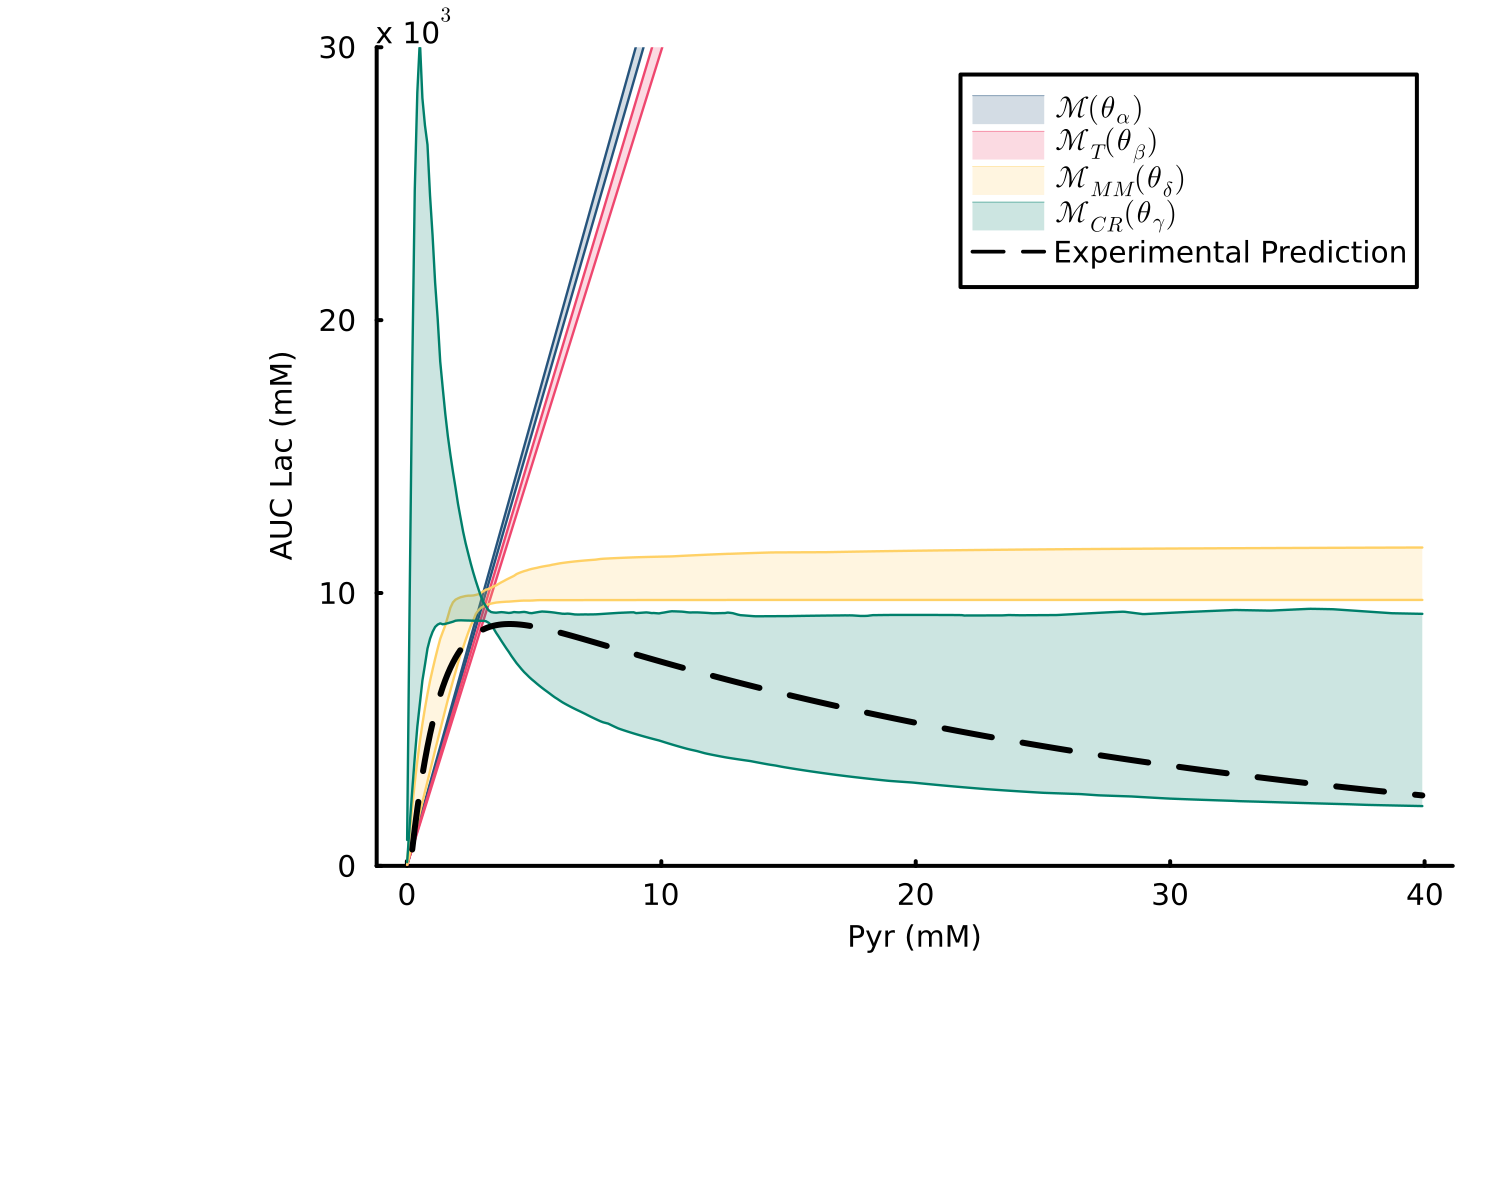

In [ ]:
# po2 = plot(PyrCons3, lacSumQuantNT[1,:]./10^3, label = "", color = ccpal[1],
# xlabel = "Pyr (mM)", ylabel = "AUC Lac (mM)", grid = false, markersize=1, markerstrokewidth=0.2, 
# linewidth=0.6, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5)
# plot!(PyrCons3, lacSumQuantNT[2,:]./10^3, label = "", color = ccpal[1], linewidth=0.6)
# plot!(PyrCons3, lacSumQuantNT[2,:]./10^3, fillrange=convert.(Float64, lacSumQuantNT[1,:]./10^3), color=ccpal[1], fillalpha=0.2, linewidth = 0, label = L"\mathcal{M}(\theta_{\alpha})")

# # -------------------------------------------------------------------------------------

# plot!(PyrCons3, lacSumQuant[1,:]./10^3, label = "", color = ccpal[2],
#   xlabel = "Pyr (mM)", ylabel = "AUC Lac (mM)", grid = false, markersize=1, markerstrokewidth=0.2, 
#   linewidth=0.6, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5)
# plot!(PyrCons3, lacSumQuant[2,:]./10^3, label = "", color = ccpal[2], linewidth=0.6)
# plot!(PyrCons3, lacSumQuant[2,:]./10^3, fillrange=convert.(Float64, lacSumQuant[1,:]./10^3), color=ccpal[2], fillalpha=0.2, linewidth = 0, label = L"\mathcal{M}_{T}(\theta_{\beta})")



# # -------------------------------------------------------------------------------------

# plot!(PyrCons3, lacSumQuantMM[1,:]./10^3, label = "", color = ccpal[3],
#   xlabel = "Pyr (mM)", ylabel = "AUC Lac (mM)", grid = false, markersize=1, markerstrokewidth=0.2, 
#   linewidth=0.6, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5)
# plot!(PyrCons3, lacSumQuantMM[2,:]./10^3, label = "", color = ccpal[3], linewidth=0.6)
# plot!(PyrCons3, lacSumQuantMM[2,:]./10^3, fillrange=convert.(Float64, lacSumQuantMM[1,:]./10^3), color=ccpal[3], fillalpha=0.2, linewidth = 0, label = L"\mathcal{M}_{MM}(\theta_{\delta})")


# # MM(Vmax, KM, Pyr) = (Vmax.*Pyr)./(KM .+ Pyr)
# # plot!(PyrCons3, MM(30, 3.2, PyrCons3), label = "")

# # # -------------------------------------------------------------------------------------

# plot!(PyrCons3, lacSumQuantCR[1,:]./10^3, label = "", color = ccpal[4],
#   xlabel = "Pyr (mM)", ylabel = "AUC Lac (mM)", grid = false, markersize=1, markerstrokewidth=0.2, 
#   linewidth=0.6, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5)
# plot!(PyrCons3, lacSumQuantCR[2,:]./10^3, label = "", color = ccpal[4], linewidth=0.6)
# plot!(PyrCons3, lacSumQuantCR[2,:]./10^3, fillrange=convert.(Float64, lacSumQuantCR[1,:]./10^3), color=ccpal[4], fillalpha=0.2, linewidth = 0, label = L"\mathcal{M}_{CR}(\theta_{\gamma})")



# # # -------------------------------------------------------------------------------------





# pp = [74.03725788756323, 144.2284171571619, 0.035560077190086616, -161.44232064449685, 0.8504800680532763]
# ss(t,p) = p[1].*(p[2].*exp.(-t.*p[3]).+p[4].*exp.(-t.*p[5]))
# oblcrl = ss(PyrCons3, pp)./10^3;
# plot!(PyrCons3[oblcrl.>0], oblcrl[oblcrl.>0], label = "Experimental Prediction", markersize=1, markerstrokewidth=0.2, 
# linewidth=1.5, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5,
# colour = "black", linestyle = :dash, ylim = [0,30])


# # scatter!([2.8],[8.5], label = "")

# annotate!(-1.2, 30.8, text("x 10"*L"^3", :black, :left, 5))



# display(po2)

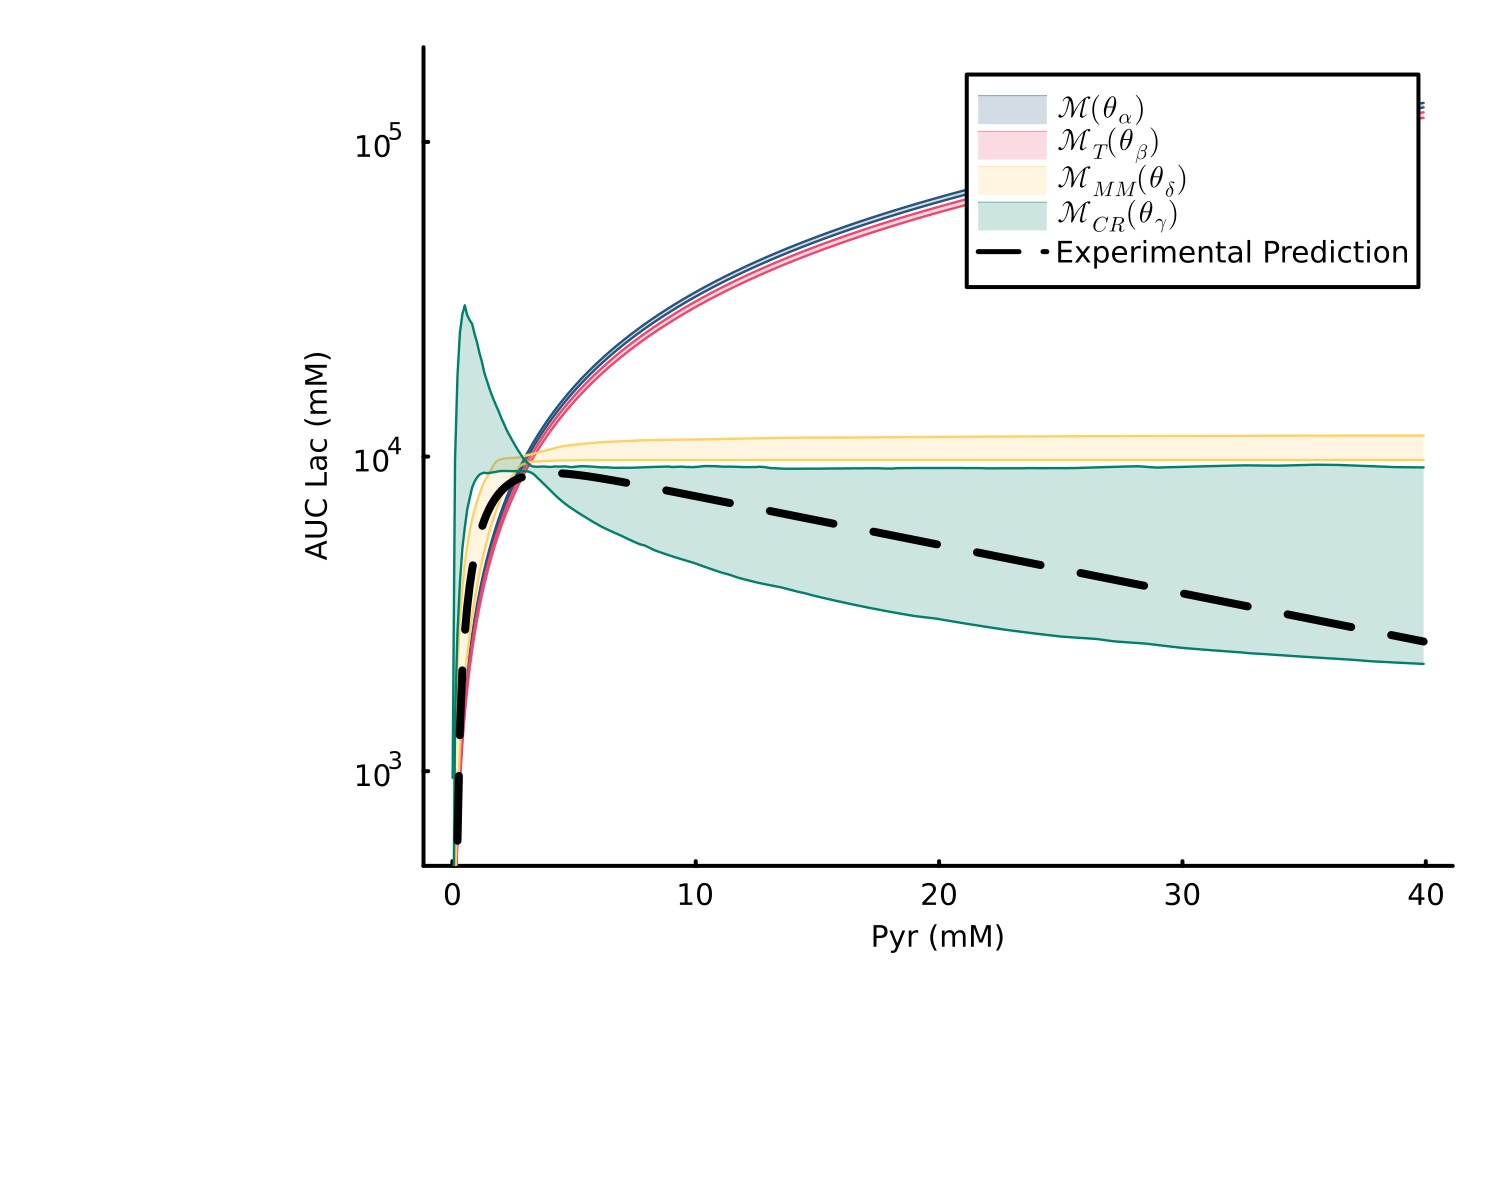

In [201]:
po2 = plot(PyrCons3, lacSumQuantNT[1,:], label = "", color = ccpal[1],
xlabel = "Pyr (mM)", ylabel = "AUC Lac (mM)", grid = false, markersize=1, markerstrokewidth=0.2, 
linewidth=0.6, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5)
plot!(PyrCons3, lacSumQuantNT[2,:], label = "", color = ccpal[1], linewidth=0.6)
plot!(PyrCons3, lacSumQuantNT[2,:], fillrange=convert.(Float64, lacSumQuantNT[1,:]), color=ccpal[1], fillalpha=0.2, linewidth = 0, label = L"\mathcal{M}(\theta_{\alpha})")

# -------------------------------------------------------------------------------------

plot!(PyrCons3, lacSumQuant[1,:], label = "", color = ccpal[2],
  xlabel = "Pyr (mM)", ylabel = "AUC Lac (mM)", grid = false, markersize=1, markerstrokewidth=0.2, 
  linewidth=0.6, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5)
plot!(PyrCons3, lacSumQuant[2,:], label = "", color = ccpal[2], linewidth=0.6)
plot!(PyrCons3, lacSumQuant[2,:], fillrange=convert.(Float64, lacSumQuant[1,:]), color=ccpal[2], fillalpha=0.2, linewidth = 0, label = L"\mathcal{M}_{T}(\theta_{\beta})")


# annotate!(-1.2, 5.8, text("x 10", :black, :left, 5))

# -------------------------------------------------------------------------------------

plot!(PyrCons3, lacSumQuantMM[1,:]./1, label = "", color = ccpal[3],
  xlabel = "Pyr (mM)", ylabel = "AUC Lac (mM)", grid = false, markersize=1, markerstrokewidth=0.2, 
  linewidth=0.6, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5)
plot!(PyrCons3, lacSumQuantMM[2,:]./1, label = "", color = ccpal[3], linewidth=0.6)
plot!(PyrCons3, lacSumQuantMM[2,:]./1, fillrange=convert.(Float64, lacSumQuantMM[1,:]./1), color=ccpal[3], fillalpha=0.2, linewidth = 0, label = L"\mathcal{M}_{MM}(\theta_{\delta})")

# -------------------------------------------------------------------------------------


plot!(PyrCons3, lacSumQuantCR[1,:]./1, label = "", color = ccpal[4],
  xlabel = "Pyr (mM)", ylabel = "AUC Lac (mM)", grid = false, markersize=1, markerstrokewidth=0.2, 
  linewidth=0.6, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5)
plot!(PyrCons3, lacSumQuantCR[2,:]./1, label = "", color = ccpal[4], linewidth=0.6)
plot!(PyrCons3, lacSumQuantCR[2,:]./1, fillrange=convert.(Float64, lacSumQuantCR[1,:]./1), color=ccpal[4], fillalpha=0.2, linewidth = 0, label = L"\mathcal{M}_{CR}(\theta_{\gamma})")



# -------------------------------------------------------------------------------------

pp = [74.03725788756323, 144.2284171571619, 0.035560077190086616, -161.44232064449685, 0.8504800680532763]
ss(t,p) = p[1].*(p[2].*exp.(-t.*p[3]).+p[4].*exp.(-t.*p[5]))
oblcrl = ss(PyrCons3, pp);
plot!(PyrCons3[oblcrl.>0], oblcrl[oblcrl.>0], label = "Experimental Prediction", markersize=1, markerstrokewidth=0.2, 
linewidth=2, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5,
colour = "black", yaxis=:log, ylim = (5*10^2, 2*10^5), linestyle=:dash)


display(po2)

In [55]:
# po2 = plot(PyrCons3, lacSumQuantNT[1,:]./10^1, label = "", color = ccpal[1],
# xlabel = "Pyr (mM)", ylabel = "Cumulative Lac (mM)", grid = false, markersize=1, markerstrokewidth=0.2, 
# linewidth=0.6, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5)
# plot!(PyrCons3, lacSumQuantNT[2,:]./10^1, label = "", color = ccpal[1], linewidth=0.6)
# plot!(PyrCons3, lacSumQuantNT[2,:]./10^1, fillrange=convert.(Float64, lacSumQuantNT[1,:]./10^1), color=ccpal[1], fillalpha=0.2, linewidth = 0, label = L"\mathcal{M}(\theta_{\alpha})")

# # -------------------------------------------------------------------------------------

# plot!(PyrCons3, lacSumQuant[1,:]./10^1, label = "", color = ccpal[2],
#   xlabel = "Pyr (mM)", ylabel = "Cumulative Lac (mM)", grid = false, markersize=1, markerstrokewidth=0.2, 
#   linewidth=0.6, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5)
# plot!(PyrCons3, lacSumQuant[2,:]./10^1, label = "", color = ccpal[2], linewidth=0.6)
# plot!(PyrCons3, lacSumQuant[2,:]./10^1, fillrange=convert.(Float64, lacSumQuant[1,:]./10^1), color=ccpal[2], fillalpha=0.2, linewidth = 0, label = L"\mathcal{M}_{T}(\theta_{\beta})")


# annotate!(-1.2, 5.8, text("x 10", :black, :left, 5))

# # -------------------------------------------------------------------------------------

# MM(Vmax, KM, Pyr) = (Vmax.*Pyr)./(KM .+ Pyr)
# plot!(PyrCons3, MM(3, 3.2, PyrCons3), label = "")

# # -------------------------------------------------------------------------------------

# pp = [14.371198503550627, 143.2069120340827, 0.03963685435918889, -157.26630408663152, 0.6200202073797068]
# ss(t,p) = p[1].*(p[2].*exp.(-t.*p[3]).+p[4].*exp.(-t.*p[5]))
# plot!(twinx(), PyrCons3, ss(PyrCons3, pp)./10^3, label = "", markersize=1, markerstrokewidth=0.2, 
# linewidth=1, size = (1500,1200), xguidefontsize=round(25/5), yguidefontsize=round(25/5), tickfontsize=round(25/5), thickness_scaling = 4, legendfontsize=5,
# ylim = (0,1.9), colour = "red", ylabel = "Cumulative Lac (A.U.)", yguidefontcolor = "red")


# annotate!(41, 5.85, text("x 10"*L"^3", :black, :left, 5))

# display(po2)